# Import the Necessary Libraries & Modules

In [2]:
from data.echogram import DataReaderZarr, get_data_readers
import numpy as np
from tqdm import tqdm
import dask
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import binary_closing
from scipy import stats as st
from pandas.plotting import scatter_matrix
import xarray as xr
import seaborn as sns
from save_Sv_patch_data_docker.ipynb import examp_illustr

dask.config.set(**{'array.slicing.split_large_chunks': False})

#  Path to surveys
survey_path = '/data/'

#  Get list of relevant surveys
surveys = ['2019/S2019847/ACOUSTIC/GRIDDED/S2019847_sv.zarr']
readers = [DataReaderZarr(survey_path + zarr_file) for zarr_file in surveys]

# Or alternatively ...
# readers = get_data_readers()

patch_size = (256, 256)  # x, y

# Defining (Copy) Functions

In [104]:
class P_refine_label_boundary():
    def __init__(self,
                 frequencies=[18, 38, 120, 200],
                 threshold_freq=200,
                 threshold_val=[1e-7, 1e-4],
                 ignore_val=-100,
                 ignore_zero_inside_bbox=True
                 ):
        self.frequencies = frequencies
        self.threshold_freq = threshold_freq
        self.threshold_val = threshold_val
        self.ignore_val = ignore_val
        self.ignore_zero_inside_bbox=ignore_zero_inside_bbox

    def __call__(self, data, labels, echogram):
        '''
        Refine existing labels based on thresholding with respect to pixel values in image.
        :param data: (numpy.array) Image (C, H, W)
        :param labels: (numpy.array) Labels corresponding to image (H, W)
        :param echogram: (Echogram object) Echogram
        :param threshold_freq: (int) Image frequency channel that is used for thresholding
        :param threshold_val: (float) Threshold value that is applied to image for assigning new labels
        :param ignore_val: (int) Ignore value (specific label value) instructs loss function not to compute gradients for these pixels
        :param ignore_zero_inside_bbox: (bool) labels==1 that is relabeled to 0 are set to ignore_value if True, 0 if False
        :return: data, new_labels, echogram
        '''

        closing = np.array([
            [0, 0, 1, 1, 1, 0, 0],
            [0, 1, 1, 1, 1, 1, 0],
            [1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1],
            [0, 1, 1, 1, 1, 1, 0],
            [0, 0, 1, 1, 1, 0, 0]
        ])

        if self.ignore_val == None:
            self.ignore_val = 0

        # Set new label for all pixels inside bounding box that are below threshold value
        if self.ignore_zero_inside_bbox:
            label_below_threshold = self.ignore_val
        else:
            label_below_threshold = 0

        # Get refined label masks
        freq_idx = self.frequencies.index(self.threshold_freq)

        # Relabel
        new_labels = labels.copy()

        mask_threshold = (labels != 0) & (labels != self.ignore_val) & (data[freq_idx, :, :] > self.threshold_val[0]) & (
                    data[freq_idx, :, :] < self.threshold_val[1])
        # Padding
        mask_threshold = np.pad(mask_threshold, ((3,3),(3,3)), 'constant')
        
        mask_threshold_closed = binary_closing(mask_threshold, structure=closing)
        
        # Remove Padding
        mask_threshold_closed = mask_threshold_closed[3:-3,3:-3]
        
        mask = (labels != 0) & (labels != self.ignore_val) & (mask_threshold_closed == 0)

        new_labels[mask] = label_below_threshold
        new_labels[labels == self.ignore_val] = self.ignore_val

        return data, new_labels, echogram

In [13]:
# Example Illustration for a patch - Echogram, annotations, Background Sv Distribution
def examp_illustr(survey, x, y, fig_start=-75, fig_finish=5, s_bin=5, db_w_limit=True, patch_size=[256, 256]):
    
    c = survey.get_label_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                               idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                               return_numpy=True)
    if db_w_limit:
        a = xr_db_with_limits(survey.get_data_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                                    idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                                    return_numpy=False, frequencies=[38000]))
        echo = a[0,:,:].values
        bg = a[0].values[np.logical_or(c==-1, c==0)] # Background
        
    else:
        a = survey.get_data_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                  idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                  return_numpy=False, frequencies=[38000])
        echo = db(a[0,:,:].values)
        bg = db(a[0].values[np.logical_or(c==-1, c==0)]) # Background             
        
        
        
    print('mean background Sv =', bg.mean(), ' median background Sv =', np.median(bg))
    print('mean Sandeel Sv =', a[0].values[c==27].mean(), ' median Sandeel Sv =', np.median(a[0].values[c==27]))
    # Echogram Plot
    plt.figure(figsize = (12,12))
    plt.suptitle('Patch Visualization at x='+str(x)+' and y='+str(y))
    
    plt.subplot(2,2,1)
    plt.title('Echogram')
    plt.imshow(echo.T)
    plt.colorbar()
    
    # Annotation Plot
    plt.subplot(2,2,3)
    plt.title('Annotations')
    plt.imshow(c.T)
    plt.colorbar()
        
    # Background Histogram Plot
    plt.subplot(2,2,2)
    plt.title('Background Sv Histogram')
    plt.hist(bg.flatten(), bins = np.arange(fig_start, fig_finish, s_bin), log = False)
    plt.xlabel('sv')
    plt.ylabel('Counts')
    plt.axvline(x=bg.mean(), color = 'black', label = 'mean')
    plt.axvline(x=np.median(bg), color = 'green', label = 'median')
    plt.axvline(x=np.nanpercentile(bg, 25), color = 'lightgray', label = '25 Percentile')
    plt.axvline(x=np.nanpercentile(bg, 75), color = 'dimgray', label = '75 Percentile')
    plt.legend()
        
    # Sandeel Histogram Plot
    plt.subplot(2,2,4)
    plt.title('Sandeel Sv Histogram')
    plt.hist(echo[c==27].flatten(),
             bins = np.arange(fig_start, fig_finish, s_bin), log = False)        
    plt.xlabel('Sv')
    plt.ylabel('Counts')
    plt.axvline(x=(echo[c==27].flatten()).mean(), color = 'red', label = 'Sandeel mean Sv')
    plt.axvline(x=np.median((echo[c==27].flatten())), color = 'orange', label = 'Sandeel median Sv')
    plt.axvline(x=np.nanpercentile(echo[c==27].flatten(), 25), color = 'lightgray', label = '25 Percentile')
    plt.axvline(x=np.nanpercentile(echo[c==27].flatten(), 75), color = 'dimgray', label = '75 Percentile')
    plt.legend()
    plt.show()    

In [ ]:
def xr_db_with_limits(xarr, limit_low=-75, limit_high=0): # Function to be applied to xarray dataarray
    data = db(xarr)
    result = data.where((data<limit_high) | (data.isnull()), limit_high)
    result = result.where((result>limit_low) | (result.isnull()), limit_low)
    return result

def db(data, eps=1e-10):
    return 10 * np.log10(data + eps)

# Background Class

In [66]:
# Modified Background Sampler for y axis - Patches are selected within the water column only, no exceed
# Near field (first 20 rows) are also excluded. the interval = [20, (seabed - 128)]
class BackgroundZarr():
    def __init__(self, zarr_files, window_size=(256, 256)):
        """
        Sample from zarr-files
        :param zarr_files: (list)
        :param window_size: (tuple)
        """
        self.zarr_files = zarr_files
        self.window_size = window_size

    def get_sample(self):
        # Select random zarr file in list
        zarr_rand = np.random.choice(self.zarr_files)

        # select random ping in zarr file
        x = np.random.randint(self.window_size[1] // 2, zarr_rand.shape[0] - self.window_size[1] // 2)

        # Get y-loc above seabed
        seabed = int(zarr_rand.get_seabed(x))


        if seabed - (self.window_size[0]+20) <= 0:
            return self.get_sample()
        y = np.random.randint(self.window_size[0]//2 + 20, seabed-self.window_size[0]//2)


        # Check if any fish_labels in the crop
        labels = zarr_rand.get_label_slice(idx_ping=x-self.window_size[1]//2,
                                           n_pings=self.window_size[1],
                                           idx_range=max(0, y-self.window_size[0]//2),
                                           n_range=self.window_size[0],
                                           drop_na=False,
                                           return_numpy=False)

        # Check if any fish-labels in crop
        if (labels > 0).any() or (labels == -1).all(): # Possible bottleneck?
            return self.get_sample()

        return [x, y], zarr_rand

# 14351 tane background class patch var benim datada

# Coordinates of random Background Samples

In [132]:
survey = [readers[0]]

crdinates = np.zeros((35000,2)) 

for i in range(len(crdinates)):
    crdinates[i, :] = BackgroundZarr(survey).get_sample()[0]
    print(f"{i}th sample, Progress = %{100*i/len(crdinates)}")

0th sample, Progress = %0.0
1th sample, Progress = %0.002857142857142857
2th sample, Progress = %0.005714285714285714
3th sample, Progress = %0.008571428571428572
4th sample, Progress = %0.011428571428571429
5th sample, Progress = %0.014285714285714285
6th sample, Progress = %0.017142857142857144
7th sample, Progress = %0.02
8th sample, Progress = %0.022857142857142857
9th sample, Progress = %0.025714285714285714
10th sample, Progress = %0.02857142857142857
11th sample, Progress = %0.03142857142857143
12th sample, Progress = %0.03428571428571429
13th sample, Progress = %0.037142857142857144
14th sample, Progress = %0.04
15th sample, Progress = %0.04285714285714286
16th sample, Progress = %0.045714285714285714
17th sample, Progress = %0.04857142857142857
18th sample, Progress = %0.05142857142857143
19th sample, Progress = %0.054285714285714284
20th sample, Progress = %0.05714285714285714
21th sample, Progress = %0.06
22th sample, Progress = %0.06285714285714286
23th sample, Progress = %

191th sample, Progress = %0.5457142857142857
192th sample, Progress = %0.5485714285714286
193th sample, Progress = %0.5514285714285714
194th sample, Progress = %0.5542857142857143
195th sample, Progress = %0.5571428571428572
196th sample, Progress = %0.56
197th sample, Progress = %0.5628571428571428
198th sample, Progress = %0.5657142857142857
199th sample, Progress = %0.5685714285714286
200th sample, Progress = %0.5714285714285714
201th sample, Progress = %0.5742857142857143
202th sample, Progress = %0.5771428571428572
203th sample, Progress = %0.58
204th sample, Progress = %0.5828571428571429
205th sample, Progress = %0.5857142857142857
206th sample, Progress = %0.5885714285714285
207th sample, Progress = %0.5914285714285714
208th sample, Progress = %0.5942857142857143
209th sample, Progress = %0.5971428571428572
210th sample, Progress = %0.6
211th sample, Progress = %0.6028571428571429
212th sample, Progress = %0.6057142857142858
213th sample, Progress = %0.6085714285714285
214th sa

382th sample, Progress = %1.0914285714285714
383th sample, Progress = %1.0942857142857143
384th sample, Progress = %1.0971428571428572
385th sample, Progress = %1.1
386th sample, Progress = %1.1028571428571428
387th sample, Progress = %1.1057142857142856
388th sample, Progress = %1.1085714285714285
389th sample, Progress = %1.1114285714285714
390th sample, Progress = %1.1142857142857143
391th sample, Progress = %1.1171428571428572
392th sample, Progress = %1.12
393th sample, Progress = %1.1228571428571428
394th sample, Progress = %1.1257142857142857
395th sample, Progress = %1.1285714285714286
396th sample, Progress = %1.1314285714285715
397th sample, Progress = %1.1342857142857143
398th sample, Progress = %1.1371428571428572
399th sample, Progress = %1.14
400th sample, Progress = %1.1428571428571428
401th sample, Progress = %1.1457142857142857
402th sample, Progress = %1.1485714285714286
403th sample, Progress = %1.1514285714285715
404th sample, Progress = %1.1542857142857144
405th sa

573th sample, Progress = %1.6371428571428572
574th sample, Progress = %1.64
575th sample, Progress = %1.6428571428571428
576th sample, Progress = %1.6457142857142857
577th sample, Progress = %1.6485714285714286
578th sample, Progress = %1.6514285714285715
579th sample, Progress = %1.6542857142857144
580th sample, Progress = %1.6571428571428573
581th sample, Progress = %1.66
582th sample, Progress = %1.6628571428571428
583th sample, Progress = %1.6657142857142857
584th sample, Progress = %1.6685714285714286
585th sample, Progress = %1.6714285714285715
586th sample, Progress = %1.6742857142857144
587th sample, Progress = %1.677142857142857
588th sample, Progress = %1.68
589th sample, Progress = %1.6828571428571428
590th sample, Progress = %1.6857142857142857
591th sample, Progress = %1.6885714285714286
592th sample, Progress = %1.6914285714285715
593th sample, Progress = %1.6942857142857144
594th sample, Progress = %1.697142857142857
595th sample, Progress = %1.7
596th sample, Progress =

765th sample, Progress = %2.1857142857142855
766th sample, Progress = %2.1885714285714286
767th sample, Progress = %2.1914285714285713
768th sample, Progress = %2.1942857142857144
769th sample, Progress = %2.197142857142857
770th sample, Progress = %2.2
771th sample, Progress = %2.202857142857143
772th sample, Progress = %2.2057142857142855
773th sample, Progress = %2.2085714285714286
774th sample, Progress = %2.2114285714285713
775th sample, Progress = %2.2142857142857144
776th sample, Progress = %2.217142857142857
777th sample, Progress = %2.22
778th sample, Progress = %2.222857142857143
779th sample, Progress = %2.2257142857142855
780th sample, Progress = %2.2285714285714286
781th sample, Progress = %2.2314285714285713
782th sample, Progress = %2.2342857142857144
783th sample, Progress = %2.237142857142857
784th sample, Progress = %2.24
785th sample, Progress = %2.242857142857143
786th sample, Progress = %2.2457142857142856
787th sample, Progress = %2.2485714285714287
788th sample, 

957th sample, Progress = %2.7342857142857144
958th sample, Progress = %2.737142857142857
959th sample, Progress = %2.74
960th sample, Progress = %2.742857142857143
961th sample, Progress = %2.7457142857142856
962th sample, Progress = %2.7485714285714287
963th sample, Progress = %2.7514285714285713
964th sample, Progress = %2.7542857142857144
965th sample, Progress = %2.757142857142857
966th sample, Progress = %2.76
967th sample, Progress = %2.762857142857143
968th sample, Progress = %2.7657142857142856
969th sample, Progress = %2.7685714285714287
970th sample, Progress = %2.7714285714285714
971th sample, Progress = %2.7742857142857145
972th sample, Progress = %2.777142857142857
973th sample, Progress = %2.78
974th sample, Progress = %2.782857142857143
975th sample, Progress = %2.7857142857142856
976th sample, Progress = %2.7885714285714287
977th sample, Progress = %2.7914285714285714
978th sample, Progress = %2.7942857142857145
979th sample, Progress = %2.797142857142857
980th sample, 

1146th sample, Progress = %3.2742857142857145
1147th sample, Progress = %3.277142857142857
1148th sample, Progress = %3.28
1149th sample, Progress = %3.282857142857143
1150th sample, Progress = %3.2857142857142856
1151th sample, Progress = %3.2885714285714287
1152th sample, Progress = %3.2914285714285714
1153th sample, Progress = %3.2942857142857145
1154th sample, Progress = %3.297142857142857
1155th sample, Progress = %3.3
1156th sample, Progress = %3.302857142857143
1157th sample, Progress = %3.3057142857142856
1158th sample, Progress = %3.3085714285714287
1159th sample, Progress = %3.3114285714285714
1160th sample, Progress = %3.3142857142857145
1161th sample, Progress = %3.317142857142857
1162th sample, Progress = %3.32
1163th sample, Progress = %3.322857142857143
1164th sample, Progress = %3.3257142857142856
1165th sample, Progress = %3.3285714285714287
1166th sample, Progress = %3.3314285714285714
1167th sample, Progress = %3.334285714285714
1168th sample, Progress = %3.337142857

1334th sample, Progress = %3.8114285714285714
1335th sample, Progress = %3.8142857142857145
1336th sample, Progress = %3.817142857142857
1337th sample, Progress = %3.82
1338th sample, Progress = %3.822857142857143
1339th sample, Progress = %3.8257142857142856
1340th sample, Progress = %3.8285714285714287
1341th sample, Progress = %3.8314285714285714
1342th sample, Progress = %3.834285714285714
1343th sample, Progress = %3.837142857142857
1344th sample, Progress = %3.84
1345th sample, Progress = %3.842857142857143
1346th sample, Progress = %3.8457142857142856
1347th sample, Progress = %3.8485714285714288
1348th sample, Progress = %3.8514285714285714
1349th sample, Progress = %3.854285714285714
1350th sample, Progress = %3.857142857142857
1351th sample, Progress = %3.86
1352th sample, Progress = %3.862857142857143
1353th sample, Progress = %3.8657142857142857
1354th sample, Progress = %3.8685714285714288
1355th sample, Progress = %3.8714285714285714
1356th sample, Progress = %3.874285714

1523th sample, Progress = %4.351428571428571
1524th sample, Progress = %4.354285714285714
1525th sample, Progress = %4.357142857142857
1526th sample, Progress = %4.36
1527th sample, Progress = %4.362857142857143
1528th sample, Progress = %4.365714285714286
1529th sample, Progress = %4.368571428571428
1530th sample, Progress = %4.371428571428571
1531th sample, Progress = %4.3742857142857146
1532th sample, Progress = %4.377142857142857
1533th sample, Progress = %4.38
1534th sample, Progress = %4.382857142857143
1535th sample, Progress = %4.385714285714286
1536th sample, Progress = %4.388571428571429
1537th sample, Progress = %4.3914285714285715
1538th sample, Progress = %4.394285714285714
1539th sample, Progress = %4.397142857142857
1540th sample, Progress = %4.4
1541th sample, Progress = %4.402857142857143
1542th sample, Progress = %4.405714285714286
1543th sample, Progress = %4.408571428571428
1544th sample, Progress = %4.411428571428571
1545th sample, Progress = %4.414285714285715
154

1713th sample, Progress = %4.894285714285714
1714th sample, Progress = %4.897142857142857
1715th sample, Progress = %4.9
1716th sample, Progress = %4.902857142857143
1717th sample, Progress = %4.905714285714286
1718th sample, Progress = %4.908571428571428
1719th sample, Progress = %4.911428571428571
1720th sample, Progress = %4.914285714285715
1721th sample, Progress = %4.917142857142857
1722th sample, Progress = %4.92
1723th sample, Progress = %4.922857142857143
1724th sample, Progress = %4.925714285714286
1725th sample, Progress = %4.928571428571429
1726th sample, Progress = %4.9314285714285715
1727th sample, Progress = %4.934285714285714
1728th sample, Progress = %4.937142857142857
1729th sample, Progress = %4.94
1730th sample, Progress = %4.942857142857143
1731th sample, Progress = %4.945714285714286
1732th sample, Progress = %4.948571428571428
1733th sample, Progress = %4.951428571428571
1734th sample, Progress = %4.954285714285715
1735th sample, Progress = %4.957142857142857
1736

1903th sample, Progress = %5.437142857142857
1904th sample, Progress = %5.44
1905th sample, Progress = %5.442857142857143
1906th sample, Progress = %5.445714285714286
1907th sample, Progress = %5.448571428571428
1908th sample, Progress = %5.451428571428571
1909th sample, Progress = %5.454285714285715
1910th sample, Progress = %5.457142857142857
1911th sample, Progress = %5.46
1912th sample, Progress = %5.462857142857143
1913th sample, Progress = %5.465714285714285
1914th sample, Progress = %5.468571428571429
1915th sample, Progress = %5.4714285714285715
1916th sample, Progress = %5.474285714285714
1917th sample, Progress = %5.477142857142857
1918th sample, Progress = %5.48
1919th sample, Progress = %5.482857142857143
1920th sample, Progress = %5.485714285714286
1921th sample, Progress = %5.488571428571428
1922th sample, Progress = %5.491428571428571
1923th sample, Progress = %5.494285714285715
1924th sample, Progress = %5.497142857142857
1925th sample, Progress = %5.5
1926th sample, Pr

2093th sample, Progress = %5.98
2094th sample, Progress = %5.982857142857143
2095th sample, Progress = %5.985714285714286
2096th sample, Progress = %5.988571428571428
2097th sample, Progress = %5.991428571428571
2098th sample, Progress = %5.994285714285715
2099th sample, Progress = %5.997142857142857
2100th sample, Progress = %6.0
2101th sample, Progress = %6.002857142857143
2102th sample, Progress = %6.005714285714285
2103th sample, Progress = %6.008571428571429
2104th sample, Progress = %6.011428571428572
2105th sample, Progress = %6.014285714285714
2106th sample, Progress = %6.017142857142857
2107th sample, Progress = %6.02
2108th sample, Progress = %6.022857142857143
2109th sample, Progress = %6.025714285714286
2110th sample, Progress = %6.0285714285714285
2111th sample, Progress = %6.031428571428571
2112th sample, Progress = %6.034285714285715
2113th sample, Progress = %6.037142857142857
2114th sample, Progress = %6.04
2115th sample, Progress = %6.042857142857143
2116th sample, Pr

2283th sample, Progress = %6.522857142857143
2284th sample, Progress = %6.525714285714286
2285th sample, Progress = %6.5285714285714285
2286th sample, Progress = %6.531428571428571
2287th sample, Progress = %6.534285714285715
2288th sample, Progress = %6.537142857142857
2289th sample, Progress = %6.54
2290th sample, Progress = %6.542857142857143
2291th sample, Progress = %6.545714285714285
2292th sample, Progress = %6.548571428571429
2293th sample, Progress = %6.551428571428572
2294th sample, Progress = %6.554285714285714
2295th sample, Progress = %6.557142857142857
2296th sample, Progress = %6.56
2297th sample, Progress = %6.562857142857143
2298th sample, Progress = %6.565714285714286
2299th sample, Progress = %6.5685714285714285
2300th sample, Progress = %6.571428571428571
2301th sample, Progress = %6.574285714285714
2302th sample, Progress = %6.577142857142857
2303th sample, Progress = %6.58
2304th sample, Progress = %6.582857142857143
2305th sample, Progress = %6.585714285714285
23

2473th sample, Progress = %7.065714285714286
2474th sample, Progress = %7.0685714285714285
2475th sample, Progress = %7.071428571428571
2476th sample, Progress = %7.074285714285714
2477th sample, Progress = %7.077142857142857
2478th sample, Progress = %7.08
2479th sample, Progress = %7.082857142857143
2480th sample, Progress = %7.085714285714285
2481th sample, Progress = %7.088571428571429
2482th sample, Progress = %7.091428571428572
2483th sample, Progress = %7.094285714285714
2484th sample, Progress = %7.097142857142857
2485th sample, Progress = %7.1
2486th sample, Progress = %7.102857142857143
2487th sample, Progress = %7.105714285714286
2488th sample, Progress = %7.1085714285714285
2489th sample, Progress = %7.111428571428571
2490th sample, Progress = %7.114285714285714
2491th sample, Progress = %7.117142857142857
2492th sample, Progress = %7.12
2493th sample, Progress = %7.122857142857143
2494th sample, Progress = %7.1257142857142854
2495th sample, Progress = %7.128571428571429
24

2663th sample, Progress = %7.6085714285714285
2664th sample, Progress = %7.611428571428571
2665th sample, Progress = %7.614285714285714
2666th sample, Progress = %7.617142857142857
2667th sample, Progress = %7.62
2668th sample, Progress = %7.622857142857143
2669th sample, Progress = %7.6257142857142854
2670th sample, Progress = %7.628571428571429
2671th sample, Progress = %7.631428571428572
2672th sample, Progress = %7.634285714285714
2673th sample, Progress = %7.637142857142857
2674th sample, Progress = %7.64
2675th sample, Progress = %7.642857142857143
2676th sample, Progress = %7.645714285714286
2677th sample, Progress = %7.648571428571429
2678th sample, Progress = %7.651428571428571
2679th sample, Progress = %7.654285714285714
2680th sample, Progress = %7.6571428571428575
2681th sample, Progress = %7.66
2682th sample, Progress = %7.662857142857143
2683th sample, Progress = %7.6657142857142855
2684th sample, Progress = %7.668571428571428
2685th sample, Progress = %7.671428571428572


2853th sample, Progress = %8.151428571428571
2854th sample, Progress = %8.154285714285715
2855th sample, Progress = %8.157142857142857
2856th sample, Progress = %8.16
2857th sample, Progress = %8.162857142857144
2858th sample, Progress = %8.165714285714285
2859th sample, Progress = %8.168571428571429
2860th sample, Progress = %8.17142857142857
2861th sample, Progress = %8.174285714285714
2862th sample, Progress = %8.177142857142858
2863th sample, Progress = %8.18
2864th sample, Progress = %8.182857142857143
2865th sample, Progress = %8.185714285714285
2866th sample, Progress = %8.188571428571429
2867th sample, Progress = %8.191428571428572
2868th sample, Progress = %8.194285714285714
2869th sample, Progress = %8.197142857142858
2870th sample, Progress = %8.2
2871th sample, Progress = %8.202857142857143
2872th sample, Progress = %8.205714285714286
2873th sample, Progress = %8.208571428571428
2874th sample, Progress = %8.211428571428572
2875th sample, Progress = %8.214285714285714
2876th

3044th sample, Progress = %8.697142857142858
3045th sample, Progress = %8.7
3046th sample, Progress = %8.702857142857143
3047th sample, Progress = %8.705714285714286
3048th sample, Progress = %8.708571428571428
3049th sample, Progress = %8.711428571428572
3050th sample, Progress = %8.714285714285714
3051th sample, Progress = %8.717142857142857
3052th sample, Progress = %8.72
3053th sample, Progress = %8.722857142857142
3054th sample, Progress = %8.725714285714286
3055th sample, Progress = %8.728571428571428
3056th sample, Progress = %8.731428571428571
3057th sample, Progress = %8.734285714285715
3058th sample, Progress = %8.737142857142857
3059th sample, Progress = %8.74
3060th sample, Progress = %8.742857142857142
3061th sample, Progress = %8.745714285714286
3062th sample, Progress = %8.748571428571429
3063th sample, Progress = %8.751428571428571
3064th sample, Progress = %8.754285714285714
3065th sample, Progress = %8.757142857142858
3066th sample, Progress = %8.76
3067th sample, Pro

3235th sample, Progress = %9.242857142857142
3236th sample, Progress = %9.245714285714286
3237th sample, Progress = %9.248571428571429
3238th sample, Progress = %9.251428571428571
3239th sample, Progress = %9.254285714285714
3240th sample, Progress = %9.257142857142858
3241th sample, Progress = %9.26
3242th sample, Progress = %9.262857142857143
3243th sample, Progress = %9.265714285714285
3244th sample, Progress = %9.268571428571429
3245th sample, Progress = %9.271428571428572
3246th sample, Progress = %9.274285714285714
3247th sample, Progress = %9.277142857142858
3248th sample, Progress = %9.28
3249th sample, Progress = %9.282857142857143
3250th sample, Progress = %9.285714285714286
3251th sample, Progress = %9.288571428571428
3252th sample, Progress = %9.291428571428572
3253th sample, Progress = %9.294285714285714
3254th sample, Progress = %9.297142857142857
3255th sample, Progress = %9.3
3256th sample, Progress = %9.302857142857142
3257th sample, Progress = %9.305714285714286
3258t

3426th sample, Progress = %9.788571428571428
3427th sample, Progress = %9.791428571428572
3428th sample, Progress = %9.794285714285714
3429th sample, Progress = %9.797142857142857
3430th sample, Progress = %9.8
3431th sample, Progress = %9.802857142857142
3432th sample, Progress = %9.805714285714286
3433th sample, Progress = %9.808571428571428
3434th sample, Progress = %9.811428571428571
3435th sample, Progress = %9.814285714285715
3436th sample, Progress = %9.817142857142857
3437th sample, Progress = %9.82
3438th sample, Progress = %9.822857142857142
3439th sample, Progress = %9.825714285714286
3440th sample, Progress = %9.82857142857143
3441th sample, Progress = %9.831428571428571
3442th sample, Progress = %9.834285714285715
3443th sample, Progress = %9.837142857142856
3444th sample, Progress = %9.84
3445th sample, Progress = %9.842857142857143
3446th sample, Progress = %9.845714285714285
3447th sample, Progress = %9.848571428571429
3448th sample, Progress = %9.851428571428572
3449th

3614th sample, Progress = %10.325714285714286
3615th sample, Progress = %10.32857142857143
3616th sample, Progress = %10.331428571428571
3617th sample, Progress = %10.334285714285715
3618th sample, Progress = %10.337142857142856
3619th sample, Progress = %10.34
3620th sample, Progress = %10.342857142857143
3621th sample, Progress = %10.345714285714285
3622th sample, Progress = %10.348571428571429
3623th sample, Progress = %10.351428571428572
3624th sample, Progress = %10.354285714285714
3625th sample, Progress = %10.357142857142858
3626th sample, Progress = %10.36
3627th sample, Progress = %10.362857142857143
3628th sample, Progress = %10.365714285714287
3629th sample, Progress = %10.368571428571428
3630th sample, Progress = %10.371428571428572
3631th sample, Progress = %10.374285714285714
3632th sample, Progress = %10.377142857142857
3633th sample, Progress = %10.38
3634th sample, Progress = %10.382857142857143
3635th sample, Progress = %10.385714285714286
3636th sample, Progress = %1

3800th sample, Progress = %10.857142857142858
3801th sample, Progress = %10.86
3802th sample, Progress = %10.862857142857143
3803th sample, Progress = %10.865714285714287
3804th sample, Progress = %10.868571428571428
3805th sample, Progress = %10.871428571428572
3806th sample, Progress = %10.874285714285714
3807th sample, Progress = %10.877142857142857
3808th sample, Progress = %10.88
3809th sample, Progress = %10.882857142857143
3810th sample, Progress = %10.885714285714286
3811th sample, Progress = %10.888571428571428
3812th sample, Progress = %10.891428571428571
3813th sample, Progress = %10.894285714285715
3814th sample, Progress = %10.897142857142857
3815th sample, Progress = %10.9
3816th sample, Progress = %10.902857142857142
3817th sample, Progress = %10.905714285714286
3818th sample, Progress = %10.90857142857143
3819th sample, Progress = %10.911428571428571
3820th sample, Progress = %10.914285714285715
3821th sample, Progress = %10.917142857142856
3822th sample, Progress = %10

3987th sample, Progress = %11.391428571428571
3988th sample, Progress = %11.394285714285715
3989th sample, Progress = %11.397142857142857
3990th sample, Progress = %11.4
3991th sample, Progress = %11.402857142857142
3992th sample, Progress = %11.405714285714286
3993th sample, Progress = %11.40857142857143
3994th sample, Progress = %11.411428571428571
3995th sample, Progress = %11.414285714285715
3996th sample, Progress = %11.417142857142856
3997th sample, Progress = %11.42
3998th sample, Progress = %11.422857142857143
3999th sample, Progress = %11.425714285714285
4000th sample, Progress = %11.428571428571429
4001th sample, Progress = %11.43142857142857
4002th sample, Progress = %11.434285714285714
4003th sample, Progress = %11.437142857142858
4004th sample, Progress = %11.44
4005th sample, Progress = %11.442857142857143
4006th sample, Progress = %11.445714285714285
4007th sample, Progress = %11.448571428571428
4008th sample, Progress = %11.451428571428572
4009th sample, Progress = %11.

4174th sample, Progress = %11.925714285714285
4175th sample, Progress = %11.928571428571429
4176th sample, Progress = %11.93142857142857
4177th sample, Progress = %11.934285714285714
4178th sample, Progress = %11.937142857142858
4179th sample, Progress = %11.94
4180th sample, Progress = %11.942857142857143
4181th sample, Progress = %11.945714285714285
4182th sample, Progress = %11.948571428571428
4183th sample, Progress = %11.951428571428572
4184th sample, Progress = %11.954285714285714
4185th sample, Progress = %11.957142857142857
4186th sample, Progress = %11.96
4187th sample, Progress = %11.962857142857143
4188th sample, Progress = %11.965714285714286
4189th sample, Progress = %11.968571428571428
4190th sample, Progress = %11.971428571428572
4191th sample, Progress = %11.974285714285715
4192th sample, Progress = %11.977142857142857
4193th sample, Progress = %11.98
4194th sample, Progress = %11.982857142857142
4195th sample, Progress = %11.985714285714286
4196th sample, Progress = %1

4360th sample, Progress = %12.457142857142857
4361th sample, Progress = %12.46
4362th sample, Progress = %12.462857142857143
4363th sample, Progress = %12.465714285714286
4364th sample, Progress = %12.468571428571428
4365th sample, Progress = %12.471428571428572
4366th sample, Progress = %12.474285714285715
4367th sample, Progress = %12.477142857142857
4368th sample, Progress = %12.48
4369th sample, Progress = %12.482857142857142
4370th sample, Progress = %12.485714285714286
4371th sample, Progress = %12.48857142857143
4372th sample, Progress = %12.491428571428571
4373th sample, Progress = %12.494285714285715
4374th sample, Progress = %12.497142857142856
4375th sample, Progress = %12.5
4376th sample, Progress = %12.502857142857144
4377th sample, Progress = %12.505714285714285
4378th sample, Progress = %12.508571428571429
4379th sample, Progress = %12.51142857142857
4380th sample, Progress = %12.514285714285714
4381th sample, Progress = %12.517142857142858
4382th sample, Progress = %12.

4547th sample, Progress = %12.991428571428571
4548th sample, Progress = %12.994285714285715
4549th sample, Progress = %12.997142857142856
4550th sample, Progress = %13.0
4551th sample, Progress = %13.002857142857144
4552th sample, Progress = %13.005714285714285
4553th sample, Progress = %13.008571428571429
4554th sample, Progress = %13.01142857142857
4555th sample, Progress = %13.014285714285714
4556th sample, Progress = %13.017142857142858
4557th sample, Progress = %13.02
4558th sample, Progress = %13.022857142857143
4559th sample, Progress = %13.025714285714285
4560th sample, Progress = %13.028571428571428
4561th sample, Progress = %13.031428571428572
4562th sample, Progress = %13.034285714285714
4563th sample, Progress = %13.037142857142857
4564th sample, Progress = %13.04
4565th sample, Progress = %13.042857142857143
4566th sample, Progress = %13.045714285714286
4567th sample, Progress = %13.048571428571428
4568th sample, Progress = %13.051428571428572
4569th sample, Progress = %13

4734th sample, Progress = %13.525714285714285
4735th sample, Progress = %13.528571428571428
4736th sample, Progress = %13.531428571428572
4737th sample, Progress = %13.534285714285714
4738th sample, Progress = %13.537142857142857
4739th sample, Progress = %13.54
4740th sample, Progress = %13.542857142857143
4741th sample, Progress = %13.545714285714286
4742th sample, Progress = %13.548571428571428
4743th sample, Progress = %13.551428571428572
4744th sample, Progress = %13.554285714285715
4745th sample, Progress = %13.557142857142857
4746th sample, Progress = %13.56
4747th sample, Progress = %13.562857142857142
4748th sample, Progress = %13.565714285714286
4749th sample, Progress = %13.56857142857143
4750th sample, Progress = %13.571428571428571
4751th sample, Progress = %13.574285714285715
4752th sample, Progress = %13.577142857142857
4753th sample, Progress = %13.58
4754th sample, Progress = %13.582857142857144
4755th sample, Progress = %13.585714285714285
4756th sample, Progress = %1

4920th sample, Progress = %14.057142857142857
4921th sample, Progress = %14.06
4922th sample, Progress = %14.062857142857142
4923th sample, Progress = %14.065714285714286
4924th sample, Progress = %14.06857142857143
4925th sample, Progress = %14.071428571428571
4926th sample, Progress = %14.074285714285715
4927th sample, Progress = %14.077142857142857
4928th sample, Progress = %14.08
4929th sample, Progress = %14.082857142857144
4930th sample, Progress = %14.085714285714285
4931th sample, Progress = %14.088571428571429
4932th sample, Progress = %14.09142857142857
4933th sample, Progress = %14.094285714285714
4934th sample, Progress = %14.097142857142858
4935th sample, Progress = %14.1
4936th sample, Progress = %14.102857142857143
4937th sample, Progress = %14.105714285714285
4938th sample, Progress = %14.108571428571429
4939th sample, Progress = %14.111428571428572
4940th sample, Progress = %14.114285714285714
4941th sample, Progress = %14.117142857142857
4942th sample, Progress = %14.

5107th sample, Progress = %14.59142857142857
5108th sample, Progress = %14.594285714285714
5109th sample, Progress = %14.597142857142858
5110th sample, Progress = %14.6
5111th sample, Progress = %14.602857142857143
5112th sample, Progress = %14.605714285714285
5113th sample, Progress = %14.608571428571429
5114th sample, Progress = %14.611428571428572
5115th sample, Progress = %14.614285714285714
5116th sample, Progress = %14.617142857142857
5117th sample, Progress = %14.62
5118th sample, Progress = %14.622857142857143
5119th sample, Progress = %14.625714285714286
5120th sample, Progress = %14.628571428571428
5121th sample, Progress = %14.631428571428572
5122th sample, Progress = %14.634285714285713
5123th sample, Progress = %14.637142857142857
5124th sample, Progress = %14.64
5125th sample, Progress = %14.642857142857142
5126th sample, Progress = %14.645714285714286
5127th sample, Progress = %14.648571428571428
5128th sample, Progress = %14.651428571428571
5129th sample, Progress = %14

5294th sample, Progress = %15.125714285714286
5295th sample, Progress = %15.128571428571428
5296th sample, Progress = %15.131428571428572
5297th sample, Progress = %15.134285714285713
5298th sample, Progress = %15.137142857142857
5299th sample, Progress = %15.14
5300th sample, Progress = %15.142857142857142
5301th sample, Progress = %15.145714285714286
5302th sample, Progress = %15.148571428571428
5303th sample, Progress = %15.151428571428571
5304th sample, Progress = %15.154285714285715
5305th sample, Progress = %15.157142857142857
5306th sample, Progress = %15.16
5307th sample, Progress = %15.162857142857144
5308th sample, Progress = %15.165714285714285
5309th sample, Progress = %15.168571428571429
5310th sample, Progress = %15.17142857142857
5311th sample, Progress = %15.174285714285714
5312th sample, Progress = %15.177142857142858
5313th sample, Progress = %15.18
5314th sample, Progress = %15.182857142857143
5315th sample, Progress = %15.185714285714285
5316th sample, Progress = %1

5480th sample, Progress = %15.657142857142857
5481th sample, Progress = %15.66
5482th sample, Progress = %15.662857142857144
5483th sample, Progress = %15.665714285714285
5484th sample, Progress = %15.668571428571429
5485th sample, Progress = %15.67142857142857
5486th sample, Progress = %15.674285714285714
5487th sample, Progress = %15.677142857142858
5488th sample, Progress = %15.68
5489th sample, Progress = %15.682857142857143
5490th sample, Progress = %15.685714285714285
5491th sample, Progress = %15.688571428571429
5492th sample, Progress = %15.691428571428572
5493th sample, Progress = %15.694285714285714
5494th sample, Progress = %15.697142857142858
5495th sample, Progress = %15.7
5496th sample, Progress = %15.702857142857143
5497th sample, Progress = %15.705714285714286
5498th sample, Progress = %15.708571428571428
5499th sample, Progress = %15.711428571428572
5500th sample, Progress = %15.714285714285714
5501th sample, Progress = %15.717142857142857
5502th sample, Progress = %15

5667th sample, Progress = %16.19142857142857
5668th sample, Progress = %16.194285714285716
5669th sample, Progress = %16.197142857142858
5670th sample, Progress = %16.2
5671th sample, Progress = %16.202857142857145
5672th sample, Progress = %16.205714285714286
5673th sample, Progress = %16.208571428571428
5674th sample, Progress = %16.21142857142857
5675th sample, Progress = %16.214285714285715
5676th sample, Progress = %16.217142857142857
5677th sample, Progress = %16.22
5678th sample, Progress = %16.222857142857144
5679th sample, Progress = %16.225714285714286
5680th sample, Progress = %16.228571428571428
5681th sample, Progress = %16.231428571428573
5682th sample, Progress = %16.234285714285715
5683th sample, Progress = %16.237142857142857
5684th sample, Progress = %16.24
5685th sample, Progress = %16.242857142857144
5686th sample, Progress = %16.245714285714286
5687th sample, Progress = %16.248571428571427
5688th sample, Progress = %16.251428571428573
5689th sample, Progress = %16.

5854th sample, Progress = %16.725714285714286
5855th sample, Progress = %16.728571428571428
5856th sample, Progress = %16.731428571428573
5857th sample, Progress = %16.734285714285715
5858th sample, Progress = %16.737142857142857
5859th sample, Progress = %16.74
5860th sample, Progress = %16.742857142857144
5861th sample, Progress = %16.745714285714286
5862th sample, Progress = %16.748571428571427
5863th sample, Progress = %16.751428571428573
5864th sample, Progress = %16.754285714285714
5865th sample, Progress = %16.757142857142856
5866th sample, Progress = %16.76
5867th sample, Progress = %16.762857142857143
5868th sample, Progress = %16.765714285714285
5869th sample, Progress = %16.768571428571427
5870th sample, Progress = %16.771428571428572
5871th sample, Progress = %16.774285714285714
5872th sample, Progress = %16.777142857142856
5873th sample, Progress = %16.78
5874th sample, Progress = %16.782857142857143
5875th sample, Progress = %16.785714285714285
5876th sample, Progress = %

6041th sample, Progress = %17.26
6042th sample, Progress = %17.262857142857143
6043th sample, Progress = %17.265714285714285
6044th sample, Progress = %17.268571428571427
6045th sample, Progress = %17.271428571428572
6046th sample, Progress = %17.274285714285714
6047th sample, Progress = %17.277142857142856
6048th sample, Progress = %17.28
6049th sample, Progress = %17.282857142857143
6050th sample, Progress = %17.285714285714285
6051th sample, Progress = %17.28857142857143
6052th sample, Progress = %17.291428571428572
6053th sample, Progress = %17.294285714285714
6054th sample, Progress = %17.297142857142855
6055th sample, Progress = %17.3
6056th sample, Progress = %17.302857142857142
6057th sample, Progress = %17.305714285714284
6058th sample, Progress = %17.30857142857143
6059th sample, Progress = %17.31142857142857
6060th sample, Progress = %17.314285714285713
6061th sample, Progress = %17.31714285714286
6062th sample, Progress = %17.32
6063th sample, Progress = %17.322857142857142

6228th sample, Progress = %17.794285714285714
6229th sample, Progress = %17.797142857142855
6230th sample, Progress = %17.8
6231th sample, Progress = %17.802857142857142
6232th sample, Progress = %17.805714285714284
6233th sample, Progress = %17.80857142857143
6234th sample, Progress = %17.81142857142857
6235th sample, Progress = %17.814285714285713
6236th sample, Progress = %17.81714285714286
6237th sample, Progress = %17.82
6238th sample, Progress = %17.822857142857142
6239th sample, Progress = %17.825714285714287
6240th sample, Progress = %17.82857142857143
6241th sample, Progress = %17.83142857142857
6242th sample, Progress = %17.834285714285713
6243th sample, Progress = %17.837142857142858
6244th sample, Progress = %17.84
6245th sample, Progress = %17.84285714285714
6246th sample, Progress = %17.845714285714287
6247th sample, Progress = %17.84857142857143
6248th sample, Progress = %17.85142857142857
6249th sample, Progress = %17.854285714285716
6250th sample, Progress = %17.857142

6415th sample, Progress = %18.32857142857143
6416th sample, Progress = %18.33142857142857
6417th sample, Progress = %18.334285714285713
6418th sample, Progress = %18.337142857142858
6419th sample, Progress = %18.34
6420th sample, Progress = %18.34285714285714
6421th sample, Progress = %18.345714285714287
6422th sample, Progress = %18.34857142857143
6423th sample, Progress = %18.35142857142857
6424th sample, Progress = %18.354285714285716
6425th sample, Progress = %18.357142857142858
6426th sample, Progress = %18.36
6427th sample, Progress = %18.36285714285714
6428th sample, Progress = %18.365714285714287
6429th sample, Progress = %18.36857142857143
6430th sample, Progress = %18.37142857142857
6431th sample, Progress = %18.374285714285715
6432th sample, Progress = %18.377142857142857
6433th sample, Progress = %18.38
6434th sample, Progress = %18.382857142857144
6435th sample, Progress = %18.385714285714286
6436th sample, Progress = %18.388571428571428
6437th sample, Progress = %18.39142

6602th sample, Progress = %18.86285714285714
6603th sample, Progress = %18.865714285714287
6604th sample, Progress = %18.86857142857143
6605th sample, Progress = %18.87142857142857
6606th sample, Progress = %18.874285714285715
6607th sample, Progress = %18.877142857142857
6608th sample, Progress = %18.88
6609th sample, Progress = %18.882857142857144
6610th sample, Progress = %18.885714285714286
6611th sample, Progress = %18.888571428571428
6612th sample, Progress = %18.89142857142857
6613th sample, Progress = %18.894285714285715
6614th sample, Progress = %18.897142857142857
6615th sample, Progress = %18.9
6616th sample, Progress = %18.902857142857144
6617th sample, Progress = %18.905714285714286
6618th sample, Progress = %18.908571428571427
6619th sample, Progress = %18.911428571428573
6620th sample, Progress = %18.914285714285715
6621th sample, Progress = %18.917142857142856
6622th sample, Progress = %18.92
6623th sample, Progress = %18.922857142857143
6624th sample, Progress = %18.92

6789th sample, Progress = %19.397142857142857
6790th sample, Progress = %19.4
6791th sample, Progress = %19.402857142857144
6792th sample, Progress = %19.405714285714286
6793th sample, Progress = %19.408571428571427
6794th sample, Progress = %19.411428571428573
6795th sample, Progress = %19.414285714285715
6796th sample, Progress = %19.417142857142856
6797th sample, Progress = %19.42
6798th sample, Progress = %19.422857142857143
6799th sample, Progress = %19.425714285714285
6800th sample, Progress = %19.428571428571427
6801th sample, Progress = %19.431428571428572
6802th sample, Progress = %19.434285714285714
6803th sample, Progress = %19.437142857142856
6804th sample, Progress = %19.44
6805th sample, Progress = %19.442857142857143
6806th sample, Progress = %19.445714285714285
6807th sample, Progress = %19.44857142857143
6808th sample, Progress = %19.451428571428572
6809th sample, Progress = %19.454285714285714
6810th sample, Progress = %19.457142857142856
6811th sample, Progress = %19

6976th sample, Progress = %19.931428571428572
6977th sample, Progress = %19.934285714285714
6978th sample, Progress = %19.937142857142856
6979th sample, Progress = %19.94
6980th sample, Progress = %19.942857142857143
6981th sample, Progress = %19.945714285714285
6982th sample, Progress = %19.94857142857143
6983th sample, Progress = %19.951428571428572
6984th sample, Progress = %19.954285714285714
6985th sample, Progress = %19.957142857142856
6986th sample, Progress = %19.96
6987th sample, Progress = %19.962857142857143
6988th sample, Progress = %19.965714285714284
6989th sample, Progress = %19.96857142857143
6990th sample, Progress = %19.97142857142857
6991th sample, Progress = %19.974285714285713
6992th sample, Progress = %19.97714285714286
6993th sample, Progress = %19.98
6994th sample, Progress = %19.982857142857142
6995th sample, Progress = %19.985714285714284
6996th sample, Progress = %19.98857142857143
6997th sample, Progress = %19.99142857142857
6998th sample, Progress = %19.994

7163th sample, Progress = %20.465714285714284
7164th sample, Progress = %20.46857142857143
7165th sample, Progress = %20.47142857142857
7166th sample, Progress = %20.474285714285713
7167th sample, Progress = %20.47714285714286
7168th sample, Progress = %20.48
7169th sample, Progress = %20.482857142857142
7170th sample, Progress = %20.485714285714284
7171th sample, Progress = %20.48857142857143
7172th sample, Progress = %20.49142857142857
7173th sample, Progress = %20.494285714285713
7174th sample, Progress = %20.497142857142858
7175th sample, Progress = %20.5
7176th sample, Progress = %20.502857142857142
7177th sample, Progress = %20.505714285714287
7178th sample, Progress = %20.50857142857143
7179th sample, Progress = %20.51142857142857
7180th sample, Progress = %20.514285714285716
7181th sample, Progress = %20.517142857142858
7182th sample, Progress = %20.52
7183th sample, Progress = %20.52285714285714
7184th sample, Progress = %20.525714285714287
7185th sample, Progress = %20.528571

7350th sample, Progress = %21.0
7351th sample, Progress = %21.002857142857142
7352th sample, Progress = %21.005714285714287
7353th sample, Progress = %21.00857142857143
7354th sample, Progress = %21.01142857142857
7355th sample, Progress = %21.014285714285716
7356th sample, Progress = %21.017142857142858
7357th sample, Progress = %21.02
7358th sample, Progress = %21.02285714285714
7359th sample, Progress = %21.025714285714287
7360th sample, Progress = %21.02857142857143
7361th sample, Progress = %21.03142857142857
7362th sample, Progress = %21.034285714285716
7363th sample, Progress = %21.037142857142857
7364th sample, Progress = %21.04
7365th sample, Progress = %21.042857142857144
7366th sample, Progress = %21.045714285714286
7367th sample, Progress = %21.048571428571428
7368th sample, Progress = %21.05142857142857
7369th sample, Progress = %21.054285714285715
7370th sample, Progress = %21.057142857142857
7371th sample, Progress = %21.06
7372th sample, Progress = %21.062857142857144
7

7537th sample, Progress = %21.534285714285716
7538th sample, Progress = %21.537142857142857
7539th sample, Progress = %21.54
7540th sample, Progress = %21.542857142857144
7541th sample, Progress = %21.545714285714286
7542th sample, Progress = %21.548571428571428
7543th sample, Progress = %21.55142857142857
7544th sample, Progress = %21.554285714285715
7545th sample, Progress = %21.557142857142857
7546th sample, Progress = %21.56
7547th sample, Progress = %21.562857142857144
7548th sample, Progress = %21.565714285714286
7549th sample, Progress = %21.568571428571428
7550th sample, Progress = %21.571428571428573
7551th sample, Progress = %21.574285714285715
7552th sample, Progress = %21.577142857142857
7553th sample, Progress = %21.58
7554th sample, Progress = %21.582857142857144
7555th sample, Progress = %21.585714285714285
7556th sample, Progress = %21.588571428571427
7557th sample, Progress = %21.591428571428573
7558th sample, Progress = %21.594285714285714
7559th sample, Progress = %2

7724th sample, Progress = %22.068571428571428
7725th sample, Progress = %22.071428571428573
7726th sample, Progress = %22.074285714285715
7727th sample, Progress = %22.077142857142857
7728th sample, Progress = %22.08
7729th sample, Progress = %22.082857142857144
7730th sample, Progress = %22.085714285714285
7731th sample, Progress = %22.088571428571427
7732th sample, Progress = %22.091428571428573
7733th sample, Progress = %22.094285714285714
7734th sample, Progress = %22.097142857142856
7735th sample, Progress = %22.1
7736th sample, Progress = %22.102857142857143
7737th sample, Progress = %22.105714285714285
7738th sample, Progress = %22.10857142857143
7739th sample, Progress = %22.111428571428572
7740th sample, Progress = %22.114285714285714
7741th sample, Progress = %22.117142857142856
7742th sample, Progress = %22.12
7743th sample, Progress = %22.122857142857143
7744th sample, Progress = %22.125714285714285
7745th sample, Progress = %22.12857142857143
7746th sample, Progress = %22.

7911th sample, Progress = %22.602857142857143
7912th sample, Progress = %22.605714285714285
7913th sample, Progress = %22.60857142857143
7914th sample, Progress = %22.611428571428572
7915th sample, Progress = %22.614285714285714
7916th sample, Progress = %22.617142857142856
7917th sample, Progress = %22.62
7918th sample, Progress = %22.622857142857143
7919th sample, Progress = %22.625714285714285
7920th sample, Progress = %22.62857142857143
7921th sample, Progress = %22.63142857142857
7922th sample, Progress = %22.634285714285713
7923th sample, Progress = %22.63714285714286
7924th sample, Progress = %22.64
7925th sample, Progress = %22.642857142857142
7926th sample, Progress = %22.645714285714284
7927th sample, Progress = %22.64857142857143
7928th sample, Progress = %22.65142857142857
7929th sample, Progress = %22.654285714285713
7930th sample, Progress = %22.65714285714286
7931th sample, Progress = %22.66
7932th sample, Progress = %22.662857142857142
7933th sample, Progress = %22.6657

8098th sample, Progress = %23.13714285714286
8099th sample, Progress = %23.14
8100th sample, Progress = %23.142857142857142
8101th sample, Progress = %23.145714285714284
8102th sample, Progress = %23.14857142857143
8103th sample, Progress = %23.15142857142857
8104th sample, Progress = %23.154285714285713
8105th sample, Progress = %23.15714285714286
8106th sample, Progress = %23.16
8107th sample, Progress = %23.162857142857142
8108th sample, Progress = %23.165714285714287
8109th sample, Progress = %23.16857142857143
8110th sample, Progress = %23.17142857142857
8111th sample, Progress = %23.174285714285713
8112th sample, Progress = %23.177142857142858
8113th sample, Progress = %23.18
8114th sample, Progress = %23.18285714285714
8115th sample, Progress = %23.185714285714287
8116th sample, Progress = %23.18857142857143
8117th sample, Progress = %23.19142857142857
8118th sample, Progress = %23.194285714285716
8119th sample, Progress = %23.197142857142858
8120th sample, Progress = %23.2
8121

8285th sample, Progress = %23.67142857142857
8286th sample, Progress = %23.674285714285713
8287th sample, Progress = %23.677142857142858
8288th sample, Progress = %23.68
8289th sample, Progress = %23.68285714285714
8290th sample, Progress = %23.685714285714287
8291th sample, Progress = %23.68857142857143
8292th sample, Progress = %23.69142857142857
8293th sample, Progress = %23.694285714285716
8294th sample, Progress = %23.697142857142858
8295th sample, Progress = %23.7
8296th sample, Progress = %23.702857142857145
8297th sample, Progress = %23.705714285714286
8298th sample, Progress = %23.708571428571428
8299th sample, Progress = %23.71142857142857
8300th sample, Progress = %23.714285714285715
8301th sample, Progress = %23.717142857142857
8302th sample, Progress = %23.72
8303th sample, Progress = %23.722857142857144
8304th sample, Progress = %23.725714285714286
8305th sample, Progress = %23.728571428571428
8306th sample, Progress = %23.731428571428573
8307th sample, Progress = %23.734

8472th sample, Progress = %24.205714285714286
8473th sample, Progress = %24.208571428571428
8474th sample, Progress = %24.21142857142857
8475th sample, Progress = %24.214285714285715
8476th sample, Progress = %24.217142857142857
8477th sample, Progress = %24.22
8478th sample, Progress = %24.222857142857144
8479th sample, Progress = %24.225714285714286
8480th sample, Progress = %24.228571428571428
8481th sample, Progress = %24.231428571428573
8482th sample, Progress = %24.234285714285715
8483th sample, Progress = %24.237142857142857
8484th sample, Progress = %24.24
8485th sample, Progress = %24.242857142857144
8486th sample, Progress = %24.245714285714286
8487th sample, Progress = %24.248571428571427
8488th sample, Progress = %24.251428571428573
8489th sample, Progress = %24.254285714285714
8490th sample, Progress = %24.257142857142856
8491th sample, Progress = %24.26
8492th sample, Progress = %24.262857142857143
8493th sample, Progress = %24.265714285714285
8494th sample, Progress = %2

8659th sample, Progress = %24.74
8660th sample, Progress = %24.742857142857144
8661th sample, Progress = %24.745714285714286
8662th sample, Progress = %24.748571428571427
8663th sample, Progress = %24.751428571428573
8664th sample, Progress = %24.754285714285714
8665th sample, Progress = %24.757142857142856
8666th sample, Progress = %24.76
8667th sample, Progress = %24.762857142857143
8668th sample, Progress = %24.765714285714285
8669th sample, Progress = %24.768571428571427
8670th sample, Progress = %24.771428571428572
8671th sample, Progress = %24.774285714285714
8672th sample, Progress = %24.777142857142856
8673th sample, Progress = %24.78
8674th sample, Progress = %24.782857142857143
8675th sample, Progress = %24.785714285714285
8676th sample, Progress = %24.78857142857143
8677th sample, Progress = %24.791428571428572
8678th sample, Progress = %24.794285714285714
8679th sample, Progress = %24.797142857142855
8680th sample, Progress = %24.8
8681th sample, Progress = %24.802857142857

8846th sample, Progress = %25.274285714285714
8847th sample, Progress = %25.277142857142856
8848th sample, Progress = %25.28
8849th sample, Progress = %25.282857142857143
8850th sample, Progress = %25.285714285714285
8851th sample, Progress = %25.28857142857143
8852th sample, Progress = %25.291428571428572
8853th sample, Progress = %25.294285714285714
8854th sample, Progress = %25.297142857142855
8855th sample, Progress = %25.3
8856th sample, Progress = %25.302857142857142
8857th sample, Progress = %25.305714285714284
8858th sample, Progress = %25.30857142857143
8859th sample, Progress = %25.31142857142857
8860th sample, Progress = %25.314285714285713
8861th sample, Progress = %25.31714285714286
8862th sample, Progress = %25.32
8863th sample, Progress = %25.322857142857142
8864th sample, Progress = %25.325714285714287
8865th sample, Progress = %25.32857142857143
8866th sample, Progress = %25.33142857142857
8867th sample, Progress = %25.334285714285713
8868th sample, Progress = %25.3371

9033th sample, Progress = %25.80857142857143
9034th sample, Progress = %25.81142857142857
9035th sample, Progress = %25.814285714285713
9036th sample, Progress = %25.81714285714286
9037th sample, Progress = %25.82
9038th sample, Progress = %25.822857142857142
9039th sample, Progress = %25.825714285714287
9040th sample, Progress = %25.82857142857143
9041th sample, Progress = %25.83142857142857
9042th sample, Progress = %25.834285714285713
9043th sample, Progress = %25.837142857142858
9044th sample, Progress = %25.84
9045th sample, Progress = %25.84285714285714
9046th sample, Progress = %25.845714285714287
9047th sample, Progress = %25.84857142857143
9048th sample, Progress = %25.85142857142857
9049th sample, Progress = %25.854285714285716
9050th sample, Progress = %25.857142857142858
9051th sample, Progress = %25.86
9052th sample, Progress = %25.86285714285714
9053th sample, Progress = %25.865714285714287
9054th sample, Progress = %25.86857142857143
9055th sample, Progress = %25.8714285

9220th sample, Progress = %26.34285714285714
9221th sample, Progress = %26.345714285714287
9222th sample, Progress = %26.34857142857143
9223th sample, Progress = %26.35142857142857
9224th sample, Progress = %26.354285714285716
9225th sample, Progress = %26.357142857142858
9226th sample, Progress = %26.36
9227th sample, Progress = %26.36285714285714
9228th sample, Progress = %26.365714285714287
9229th sample, Progress = %26.36857142857143
9230th sample, Progress = %26.37142857142857
9231th sample, Progress = %26.374285714285715
9232th sample, Progress = %26.377142857142857
9233th sample, Progress = %26.38
9234th sample, Progress = %26.382857142857144
9235th sample, Progress = %26.385714285714286
9236th sample, Progress = %26.388571428571428
9237th sample, Progress = %26.39142857142857
9238th sample, Progress = %26.394285714285715
9239th sample, Progress = %26.397142857142857
9240th sample, Progress = %26.4
9241th sample, Progress = %26.402857142857144
9242th sample, Progress = %26.40571

9407th sample, Progress = %26.877142857142857
9408th sample, Progress = %26.88
9409th sample, Progress = %26.882857142857144
9410th sample, Progress = %26.885714285714286
9411th sample, Progress = %26.888571428571428
9412th sample, Progress = %26.89142857142857
9413th sample, Progress = %26.894285714285715
9414th sample, Progress = %26.897142857142857
9415th sample, Progress = %26.9
9416th sample, Progress = %26.902857142857144
9417th sample, Progress = %26.905714285714286
9418th sample, Progress = %26.908571428571427
9419th sample, Progress = %26.911428571428573
9420th sample, Progress = %26.914285714285715
9421th sample, Progress = %26.917142857142856
9422th sample, Progress = %26.92
9423th sample, Progress = %26.922857142857143
9424th sample, Progress = %26.925714285714285
9425th sample, Progress = %26.928571428571427
9426th sample, Progress = %26.931428571428572
9427th sample, Progress = %26.934285714285714
9428th sample, Progress = %26.937142857142856
9429th sample, Progress = %26

9594th sample, Progress = %27.411428571428573
9595th sample, Progress = %27.414285714285715
9596th sample, Progress = %27.417142857142856
9597th sample, Progress = %27.42
9598th sample, Progress = %27.422857142857143
9599th sample, Progress = %27.425714285714285
9600th sample, Progress = %27.428571428571427
9601th sample, Progress = %27.431428571428572
9602th sample, Progress = %27.434285714285714
9603th sample, Progress = %27.437142857142856
9604th sample, Progress = %27.44
9605th sample, Progress = %27.442857142857143
9606th sample, Progress = %27.445714285714285
9607th sample, Progress = %27.44857142857143
9608th sample, Progress = %27.451428571428572
9609th sample, Progress = %27.454285714285714
9610th sample, Progress = %27.457142857142856
9611th sample, Progress = %27.46
9612th sample, Progress = %27.462857142857143
9613th sample, Progress = %27.465714285714284
9614th sample, Progress = %27.46857142857143
9615th sample, Progress = %27.47142857142857
9616th sample, Progress = %27.

9781th sample, Progress = %27.945714285714285
9782th sample, Progress = %27.94857142857143
9783th sample, Progress = %27.951428571428572
9784th sample, Progress = %27.954285714285714
9785th sample, Progress = %27.957142857142856
9786th sample, Progress = %27.96
9787th sample, Progress = %27.962857142857143
9788th sample, Progress = %27.965714285714284
9789th sample, Progress = %27.96857142857143
9790th sample, Progress = %27.97142857142857
9791th sample, Progress = %27.974285714285713
9792th sample, Progress = %27.97714285714286
9793th sample, Progress = %27.98
9794th sample, Progress = %27.982857142857142
9795th sample, Progress = %27.985714285714284
9796th sample, Progress = %27.98857142857143
9797th sample, Progress = %27.99142857142857
9798th sample, Progress = %27.994285714285713
9799th sample, Progress = %27.997142857142858
9800th sample, Progress = %28.0
9801th sample, Progress = %28.002857142857142
9802th sample, Progress = %28.005714285714287
9803th sample, Progress = %28.0085

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14817th sample, Progress = %42.33428571428571
14818th sample, Progress = %42.33714285714286
14819th sample, Progress = %42.34
14820th sample, Progress = %42.34285714285714
14821th sample, Progress = %42.34571428571429
14822th sample, Progress = %42.348571428571425
14823th sample, Progress = %42.35142857142857
14824th sample, Progress = %42.354285714285716
14825th sample, Progress = %42.357142857142854
14826th sample, Progress = %42.36
14827th sample, Progress = %42.362857142857145
14828th sample, Progress = %42.36571428571428
14829th sample, Progress = %42.36857142857143
14830th sample, Progress = %42.371428571428574
14831th sample, Progress = %42.37428571428571
14832th sample, Progress = %42.37714285714286
14833th sample, Progress = %42.38
14834th sample, Progress = %42.38285714285714
14835th sample, Progress = %42.385714285714286
14836th sample, Progress = %42.38857142857143
14837th sample, Progress = %42.39142857142857
14838th sample, Progress = %42.394285714285715
14839th sample, P

15001th sample, Progress = %42.86
15002th sample, Progress = %42.862857142857145
15003th sample, Progress = %42.86571428571428
15004th sample, Progress = %42.86857142857143
15005th sample, Progress = %42.871428571428574
15006th sample, Progress = %42.87428571428571
15007th sample, Progress = %42.87714285714286
15008th sample, Progress = %42.88
15009th sample, Progress = %42.88285714285714
15010th sample, Progress = %42.885714285714286
15011th sample, Progress = %42.88857142857143
15012th sample, Progress = %42.89142857142857
15013th sample, Progress = %42.894285714285715
15014th sample, Progress = %42.89714285714286
15015th sample, Progress = %42.9
15016th sample, Progress = %42.902857142857144
15017th sample, Progress = %42.90571428571429
15018th sample, Progress = %42.90857142857143
15019th sample, Progress = %42.91142857142857
15020th sample, Progress = %42.91428571428571
15021th sample, Progress = %42.917142857142856
15022th sample, Progress = %42.92
15023th sample, Progress = %42.

15186th sample, Progress = %43.38857142857143
15187th sample, Progress = %43.39142857142857
15188th sample, Progress = %43.394285714285715
15189th sample, Progress = %43.39714285714286
15190th sample, Progress = %43.4
15191th sample, Progress = %43.402857142857144
15192th sample, Progress = %43.40571428571429
15193th sample, Progress = %43.40857142857143
15194th sample, Progress = %43.41142857142857
15195th sample, Progress = %43.41428571428571
15196th sample, Progress = %43.417142857142856
15197th sample, Progress = %43.42
15198th sample, Progress = %43.42285714285714
15199th sample, Progress = %43.425714285714285
15200th sample, Progress = %43.42857142857143
15201th sample, Progress = %43.43142857142857
15202th sample, Progress = %43.434285714285714
15203th sample, Progress = %43.43714285714286
15204th sample, Progress = %43.44
15205th sample, Progress = %43.44285714285714
15206th sample, Progress = %43.44571428571429
15207th sample, Progress = %43.44857142857143
15208th sample, Prog

15370th sample, Progress = %43.91428571428571
15371th sample, Progress = %43.917142857142856
15372th sample, Progress = %43.92
15373th sample, Progress = %43.92285714285714
15374th sample, Progress = %43.925714285714285
15375th sample, Progress = %43.92857142857143
15376th sample, Progress = %43.93142857142857
15377th sample, Progress = %43.934285714285714
15378th sample, Progress = %43.93714285714286
15379th sample, Progress = %43.94
15380th sample, Progress = %43.94285714285714
15381th sample, Progress = %43.94571428571429
15382th sample, Progress = %43.94857142857143
15383th sample, Progress = %43.95142857142857
15384th sample, Progress = %43.95428571428572
15385th sample, Progress = %43.957142857142856
15386th sample, Progress = %43.96
15387th sample, Progress = %43.962857142857146
15388th sample, Progress = %43.965714285714284
15389th sample, Progress = %43.96857142857143
15390th sample, Progress = %43.97142857142857
15391th sample, Progress = %43.97428571428571
15392th sample, Pr

15554th sample, Progress = %44.44
15555th sample, Progress = %44.44285714285714
15556th sample, Progress = %44.44571428571429
15557th sample, Progress = %44.44857142857143
15558th sample, Progress = %44.45142857142857
15559th sample, Progress = %44.45428571428572
15560th sample, Progress = %44.457142857142856
15561th sample, Progress = %44.46
15562th sample, Progress = %44.462857142857146
15563th sample, Progress = %44.465714285714284
15564th sample, Progress = %44.46857142857143
15565th sample, Progress = %44.47142857142857
15566th sample, Progress = %44.47428571428571
15567th sample, Progress = %44.47714285714286
15568th sample, Progress = %44.48
15569th sample, Progress = %44.48285714285714
15570th sample, Progress = %44.48571428571429
15571th sample, Progress = %44.488571428571426
15572th sample, Progress = %44.49142857142857
15573th sample, Progress = %44.494285714285716
15574th sample, Progress = %44.497142857142855
15575th sample, Progress = %44.5
15576th sample, Progress = %44.

15739th sample, Progress = %44.96857142857143
15740th sample, Progress = %44.97142857142857
15741th sample, Progress = %44.97428571428571
15742th sample, Progress = %44.97714285714286
15743th sample, Progress = %44.98
15744th sample, Progress = %44.98285714285714
15745th sample, Progress = %44.98571428571429
15746th sample, Progress = %44.988571428571426
15747th sample, Progress = %44.99142857142857
15748th sample, Progress = %44.994285714285716
15749th sample, Progress = %44.997142857142855
15750th sample, Progress = %45.0
15751th sample, Progress = %45.002857142857145
15752th sample, Progress = %45.005714285714284
15753th sample, Progress = %45.00857142857143
15754th sample, Progress = %45.011428571428574
15755th sample, Progress = %45.01428571428571
15756th sample, Progress = %45.01714285714286
15757th sample, Progress = %45.02
15758th sample, Progress = %45.02285714285714
15759th sample, Progress = %45.02571428571429
15760th sample, Progress = %45.02857142857143
15761th sample, Pro

15923th sample, Progress = %45.494285714285716
15924th sample, Progress = %45.497142857142855
15925th sample, Progress = %45.5
15926th sample, Progress = %45.502857142857145
15927th sample, Progress = %45.505714285714284
15928th sample, Progress = %45.50857142857143
15929th sample, Progress = %45.511428571428574
15930th sample, Progress = %45.51428571428571
15931th sample, Progress = %45.51714285714286
15932th sample, Progress = %45.52
15933th sample, Progress = %45.52285714285714
15934th sample, Progress = %45.52571428571429
15935th sample, Progress = %45.52857142857143
15936th sample, Progress = %45.53142857142857
15937th sample, Progress = %45.534285714285716
15938th sample, Progress = %45.537142857142854
15939th sample, Progress = %45.54
15940th sample, Progress = %45.542857142857144
15941th sample, Progress = %45.54571428571428
15942th sample, Progress = %45.54857142857143
15943th sample, Progress = %45.55142857142857
15944th sample, Progress = %45.55428571428571
15945th sample, P

16107th sample, Progress = %46.02
16108th sample, Progress = %46.02285714285714
16109th sample, Progress = %46.02571428571429
16110th sample, Progress = %46.02857142857143
16111th sample, Progress = %46.03142857142857
16112th sample, Progress = %46.034285714285716
16113th sample, Progress = %46.037142857142854
16114th sample, Progress = %46.04
16115th sample, Progress = %46.042857142857144
16116th sample, Progress = %46.04571428571428
16117th sample, Progress = %46.04857142857143
16118th sample, Progress = %46.05142857142857
16119th sample, Progress = %46.05428571428571
16120th sample, Progress = %46.05714285714286
16121th sample, Progress = %46.06
16122th sample, Progress = %46.06285714285714
16123th sample, Progress = %46.065714285714286
16124th sample, Progress = %46.06857142857143
16125th sample, Progress = %46.07142857142857
16126th sample, Progress = %46.074285714285715
16127th sample, Progress = %46.07714285714286
16128th sample, Progress = %46.08
16129th sample, Progress = %46.

16292th sample, Progress = %46.54857142857143
16293th sample, Progress = %46.55142857142857
16294th sample, Progress = %46.55428571428571
16295th sample, Progress = %46.55714285714286
16296th sample, Progress = %46.56
16297th sample, Progress = %46.56285714285714
16298th sample, Progress = %46.565714285714286
16299th sample, Progress = %46.56857142857143
16300th sample, Progress = %46.57142857142857
16301th sample, Progress = %46.574285714285715
16302th sample, Progress = %46.57714285714286
16303th sample, Progress = %46.58
16304th sample, Progress = %46.582857142857144
16305th sample, Progress = %46.58571428571429
16306th sample, Progress = %46.58857142857143
16307th sample, Progress = %46.59142857142857
16308th sample, Progress = %46.59428571428571
16309th sample, Progress = %46.597142857142856
16310th sample, Progress = %46.6
16311th sample, Progress = %46.60285714285714
16312th sample, Progress = %46.605714285714285
16313th sample, Progress = %46.60857142857143
16314th sample, Prog

16476th sample, Progress = %47.074285714285715
16477th sample, Progress = %47.07714285714286
16478th sample, Progress = %47.08
16479th sample, Progress = %47.082857142857144
16480th sample, Progress = %47.08571428571429
16481th sample, Progress = %47.08857142857143
16482th sample, Progress = %47.09142857142857
16483th sample, Progress = %47.09428571428571
16484th sample, Progress = %47.097142857142856
16485th sample, Progress = %47.1
16486th sample, Progress = %47.10285714285714
16487th sample, Progress = %47.105714285714285
16488th sample, Progress = %47.10857142857143
16489th sample, Progress = %47.11142857142857
16490th sample, Progress = %47.114285714285714
16491th sample, Progress = %47.11714285714286
16492th sample, Progress = %47.12
16493th sample, Progress = %47.12285714285714
16494th sample, Progress = %47.12571428571429
16495th sample, Progress = %47.128571428571426
16496th sample, Progress = %47.13142857142857
16497th sample, Progress = %47.13428571428572
16498th sample, Pro

16660th sample, Progress = %47.6
16661th sample, Progress = %47.60285714285714
16662th sample, Progress = %47.605714285714285
16663th sample, Progress = %47.60857142857143
16664th sample, Progress = %47.61142857142857
16665th sample, Progress = %47.614285714285714
16666th sample, Progress = %47.61714285714286
16667th sample, Progress = %47.62
16668th sample, Progress = %47.62285714285714
16669th sample, Progress = %47.62571428571429
16670th sample, Progress = %47.628571428571426
16671th sample, Progress = %47.63142857142857
16672th sample, Progress = %47.63428571428572
16673th sample, Progress = %47.637142857142855
16674th sample, Progress = %47.64
16675th sample, Progress = %47.642857142857146
16676th sample, Progress = %47.645714285714284
16677th sample, Progress = %47.64857142857143
16678th sample, Progress = %47.651428571428575
16679th sample, Progress = %47.65428571428571
16680th sample, Progress = %47.65714285714286
16681th sample, Progress = %47.66
16682th sample, Progress = %47

16845th sample, Progress = %48.128571428571426
16846th sample, Progress = %48.13142857142857
16847th sample, Progress = %48.13428571428572
16848th sample, Progress = %48.137142857142855
16849th sample, Progress = %48.14
16850th sample, Progress = %48.142857142857146
16851th sample, Progress = %48.145714285714284
16852th sample, Progress = %48.14857142857143
16853th sample, Progress = %48.151428571428575
16854th sample, Progress = %48.15428571428571
16855th sample, Progress = %48.15714285714286
16856th sample, Progress = %48.16
16857th sample, Progress = %48.16285714285714
16858th sample, Progress = %48.16571428571429
16859th sample, Progress = %48.168571428571425
16860th sample, Progress = %48.17142857142857
16861th sample, Progress = %48.174285714285716
16862th sample, Progress = %48.177142857142854
16863th sample, Progress = %48.18
16864th sample, Progress = %48.182857142857145
16865th sample, Progress = %48.18571428571428
16866th sample, Progress = %48.18857142857143
16867th sample,

17029th sample, Progress = %48.65428571428571
17030th sample, Progress = %48.65714285714286
17031th sample, Progress = %48.66
17032th sample, Progress = %48.66285714285714
17033th sample, Progress = %48.66571428571429
17034th sample, Progress = %48.668571428571425
17035th sample, Progress = %48.67142857142857
17036th sample, Progress = %48.674285714285716
17037th sample, Progress = %48.677142857142854
17038th sample, Progress = %48.68
17039th sample, Progress = %48.682857142857145
17040th sample, Progress = %48.68571428571428
17041th sample, Progress = %48.68857142857143
17042th sample, Progress = %48.691428571428574
17043th sample, Progress = %48.69428571428571
17044th sample, Progress = %48.69714285714286
17045th sample, Progress = %48.7
17046th sample, Progress = %48.70285714285714
17047th sample, Progress = %48.705714285714286
17048th sample, Progress = %48.70857142857143
17049th sample, Progress = %48.71142857142857
17050th sample, Progress = %48.714285714285715
17051th sample, Pr

17213th sample, Progress = %49.18
17214th sample, Progress = %49.182857142857145
17215th sample, Progress = %49.18571428571428
17216th sample, Progress = %49.18857142857143
17217th sample, Progress = %49.191428571428574
17218th sample, Progress = %49.19428571428571
17219th sample, Progress = %49.19714285714286
17220th sample, Progress = %49.2
17221th sample, Progress = %49.20285714285714
17222th sample, Progress = %49.205714285714286
17223th sample, Progress = %49.20857142857143
17224th sample, Progress = %49.21142857142857
17225th sample, Progress = %49.214285714285715
17226th sample, Progress = %49.21714285714286
17227th sample, Progress = %49.22
17228th sample, Progress = %49.222857142857144
17229th sample, Progress = %49.22571428571428
17230th sample, Progress = %49.22857142857143
17231th sample, Progress = %49.23142857142857
17232th sample, Progress = %49.23428571428571
17233th sample, Progress = %49.23714285714286
17234th sample, Progress = %49.24
17235th sample, Progress = %49.2

17398th sample, Progress = %49.70857142857143
17399th sample, Progress = %49.71142857142857
17400th sample, Progress = %49.714285714285715
17401th sample, Progress = %49.71714285714286
17402th sample, Progress = %49.72
17403th sample, Progress = %49.722857142857144
17404th sample, Progress = %49.72571428571428
17405th sample, Progress = %49.72857142857143
17406th sample, Progress = %49.73142857142857
17407th sample, Progress = %49.73428571428571
17408th sample, Progress = %49.73714285714286
17409th sample, Progress = %49.74
17410th sample, Progress = %49.74285714285714
17411th sample, Progress = %49.745714285714286
17412th sample, Progress = %49.74857142857143
17413th sample, Progress = %49.75142857142857
17414th sample, Progress = %49.754285714285714
17415th sample, Progress = %49.75714285714286
17416th sample, Progress = %49.76
17417th sample, Progress = %49.76285714285714
17418th sample, Progress = %49.76571428571429
17419th sample, Progress = %49.76857142857143
17420th sample, Prog

17582th sample, Progress = %50.23428571428571
17583th sample, Progress = %50.23714285714286
17584th sample, Progress = %50.24
17585th sample, Progress = %50.24285714285714
17586th sample, Progress = %50.245714285714286
17587th sample, Progress = %50.24857142857143
17588th sample, Progress = %50.25142857142857
17589th sample, Progress = %50.254285714285714
17590th sample, Progress = %50.25714285714286
17591th sample, Progress = %50.26
17592th sample, Progress = %50.26285714285714
17593th sample, Progress = %50.26571428571429
17594th sample, Progress = %50.26857142857143
17595th sample, Progress = %50.27142857142857
17596th sample, Progress = %50.27428571428572
17597th sample, Progress = %50.277142857142856
17598th sample, Progress = %50.28
17599th sample, Progress = %50.28285714285714
17600th sample, Progress = %50.285714285714285
17601th sample, Progress = %50.28857142857143
17602th sample, Progress = %50.29142857142857
17603th sample, Progress = %50.294285714285714
17604th sample, Pro

17766th sample, Progress = %50.76
17767th sample, Progress = %50.76285714285714
17768th sample, Progress = %50.76571428571429
17769th sample, Progress = %50.76857142857143
17770th sample, Progress = %50.77142857142857
17771th sample, Progress = %50.77428571428572
17772th sample, Progress = %50.777142857142856
17773th sample, Progress = %50.78
17774th sample, Progress = %50.78285714285714
17775th sample, Progress = %50.785714285714285
17776th sample, Progress = %50.78857142857143
17777th sample, Progress = %50.79142857142857
17778th sample, Progress = %50.794285714285714
17779th sample, Progress = %50.79714285714286
17780th sample, Progress = %50.8
17781th sample, Progress = %50.80285714285714
17782th sample, Progress = %50.80571428571429
17783th sample, Progress = %50.808571428571426
17784th sample, Progress = %50.81142857142857
17785th sample, Progress = %50.81428571428572
17786th sample, Progress = %50.817142857142855
17787th sample, Progress = %50.82
17788th sample, Progress = %50.8

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22532th sample, Progress = %64.37714285714286
22533th sample, Progress = %64.38
22534th sample, Progress = %64.38285714285715
22535th sample, Progress = %64.38571428571429
22536th sample, Progress = %64.38857142857142
22537th sample, Progress = %64.39142857142858
22538th sample, Progress = %64.39428571428572
22539th sample, Progress = %64.39714285714285
22540th sample, Progress = %64.4
22541th sample, Progress = %64.40285714285714
22542th sample, Progress = %64.40571428571428
22543th sample, Progress = %64.40857142857143
22544th sample, Progress = %64.41142857142857
22545th sample, Progress = %64.41428571428571
22546th sample, Progress = %64.41714285714286
22547th sample, Progress = %64.42
22548th sample, Progress = %64.42285714285714
22549th sample, Progress = %64.42571428571429
22550th sample, Progress = %64.42857142857143
22551th sample, Progress = %64.43142857142857
22552th sample, Progress = %64.43428571428572
22553th sample, Progress = %64.43714285714286
22554th sample, Progress 

22718th sample, Progress = %64.90857142857143
22719th sample, Progress = %64.91142857142857
22720th sample, Progress = %64.91428571428571
22721th sample, Progress = %64.91714285714286
22722th sample, Progress = %64.92
22723th sample, Progress = %64.92285714285714
22724th sample, Progress = %64.92571428571429
22725th sample, Progress = %64.92857142857143
22726th sample, Progress = %64.93142857142857
22727th sample, Progress = %64.93428571428572
22728th sample, Progress = %64.93714285714286
22729th sample, Progress = %64.94
22730th sample, Progress = %64.94285714285714
22731th sample, Progress = %64.94571428571429
22732th sample, Progress = %64.94857142857143
22733th sample, Progress = %64.95142857142856
22734th sample, Progress = %64.95428571428572
22735th sample, Progress = %64.95714285714286
22736th sample, Progress = %64.96
22737th sample, Progress = %64.96285714285715
22738th sample, Progress = %64.96571428571428
22739th sample, Progress = %64.96857142857142
22740th sample, Progress

22903th sample, Progress = %65.43714285714286
22904th sample, Progress = %65.44
22905th sample, Progress = %65.44285714285714
22906th sample, Progress = %65.44571428571429
22907th sample, Progress = %65.44857142857143
22908th sample, Progress = %65.45142857142856
22909th sample, Progress = %65.45428571428572
22910th sample, Progress = %65.45714285714286
22911th sample, Progress = %65.46
22912th sample, Progress = %65.46285714285715
22913th sample, Progress = %65.46571428571428
22914th sample, Progress = %65.46857142857142
22915th sample, Progress = %65.47142857142858
22916th sample, Progress = %65.47428571428571
22917th sample, Progress = %65.47714285714285
22918th sample, Progress = %65.48
22919th sample, Progress = %65.48285714285714
22920th sample, Progress = %65.48571428571428
22921th sample, Progress = %65.48857142857143
22922th sample, Progress = %65.49142857142857
22923th sample, Progress = %65.49428571428571
22924th sample, Progress = %65.49714285714286
22925th sample, Progress

23089th sample, Progress = %65.96857142857142
23090th sample, Progress = %65.97142857142858
23091th sample, Progress = %65.97428571428571
23092th sample, Progress = %65.97714285714285
23093th sample, Progress = %65.98
23094th sample, Progress = %65.98285714285714
23095th sample, Progress = %65.98571428571428
23096th sample, Progress = %65.98857142857143
23097th sample, Progress = %65.99142857142857
23098th sample, Progress = %65.99428571428571
23099th sample, Progress = %65.99714285714286
23100th sample, Progress = %66.0
23101th sample, Progress = %66.00285714285714
23102th sample, Progress = %66.00571428571429
23103th sample, Progress = %66.00857142857143
23104th sample, Progress = %66.01142857142857
23105th sample, Progress = %66.01428571428572
23106th sample, Progress = %66.01714285714286
23107th sample, Progress = %66.02
23108th sample, Progress = %66.02285714285715
23109th sample, Progress = %66.02571428571429
23110th sample, Progress = %66.02857142857142
23111th sample, Progress 

23274th sample, Progress = %66.49714285714286
23275th sample, Progress = %66.5
23276th sample, Progress = %66.50285714285714
23277th sample, Progress = %66.50571428571429
23278th sample, Progress = %66.50857142857143
23279th sample, Progress = %66.51142857142857
23280th sample, Progress = %66.51428571428572
23281th sample, Progress = %66.51714285714286
23282th sample, Progress = %66.52
23283th sample, Progress = %66.52285714285715
23284th sample, Progress = %66.52571428571429
23285th sample, Progress = %66.52857142857142
23286th sample, Progress = %66.53142857142858
23287th sample, Progress = %66.53428571428572
23288th sample, Progress = %66.53714285714285
23289th sample, Progress = %66.54
23290th sample, Progress = %66.54285714285714
23291th sample, Progress = %66.54571428571428
23292th sample, Progress = %66.54857142857144
23293th sample, Progress = %66.55142857142857
23294th sample, Progress = %66.55428571428571
23295th sample, Progress = %66.55714285714286
23296th sample, Progress 

23460th sample, Progress = %67.02857142857142
23461th sample, Progress = %67.03142857142858
23462th sample, Progress = %67.03428571428572
23463th sample, Progress = %67.03714285714285
23464th sample, Progress = %67.04
23465th sample, Progress = %67.04285714285714
23466th sample, Progress = %67.04571428571428
23467th sample, Progress = %67.04857142857144
23468th sample, Progress = %67.05142857142857
23469th sample, Progress = %67.05428571428571
23470th sample, Progress = %67.05714285714286
23471th sample, Progress = %67.06
23472th sample, Progress = %67.06285714285714
23473th sample, Progress = %67.06571428571428
23474th sample, Progress = %67.06857142857143
23475th sample, Progress = %67.07142857142857
23476th sample, Progress = %67.07428571428571
23477th sample, Progress = %67.07714285714286
23478th sample, Progress = %67.08
23479th sample, Progress = %67.08285714285714
23480th sample, Progress = %67.08571428571429
23481th sample, Progress = %67.08857142857143
23482th sample, Progress

23645th sample, Progress = %67.55714285714286
23646th sample, Progress = %67.56
23647th sample, Progress = %67.56285714285714
23648th sample, Progress = %67.56571428571428
23649th sample, Progress = %67.56857142857143
23650th sample, Progress = %67.57142857142857
23651th sample, Progress = %67.57428571428571
23652th sample, Progress = %67.57714285714286
23653th sample, Progress = %67.58
23654th sample, Progress = %67.58285714285714
23655th sample, Progress = %67.58571428571429
23656th sample, Progress = %67.58857142857143
23657th sample, Progress = %67.59142857142857
23658th sample, Progress = %67.59428571428572
23659th sample, Progress = %67.59714285714286
23660th sample, Progress = %67.6
23661th sample, Progress = %67.60285714285715
23662th sample, Progress = %67.60571428571428
23663th sample, Progress = %67.60857142857142
23664th sample, Progress = %67.61142857142858
23665th sample, Progress = %67.61428571428571
23666th sample, Progress = %67.61714285714285
23667th sample, Progress 

23831th sample, Progress = %68.08857142857143
23832th sample, Progress = %68.09142857142857
23833th sample, Progress = %68.09428571428572
23834th sample, Progress = %68.09714285714286
23835th sample, Progress = %68.1
23836th sample, Progress = %68.10285714285715
23837th sample, Progress = %68.10571428571428
23838th sample, Progress = %68.10857142857142
23839th sample, Progress = %68.11142857142858
23840th sample, Progress = %68.11428571428571
23841th sample, Progress = %68.11714285714285
23842th sample, Progress = %68.12
23843th sample, Progress = %68.12285714285714
23844th sample, Progress = %68.12571428571428
23845th sample, Progress = %68.12857142857143
23846th sample, Progress = %68.13142857142857
23847th sample, Progress = %68.13428571428571
23848th sample, Progress = %68.13714285714286
23849th sample, Progress = %68.14
23850th sample, Progress = %68.14285714285714
23851th sample, Progress = %68.14571428571429
23852th sample, Progress = %68.14857142857143
23853th sample, Progress 

24017th sample, Progress = %68.62
24018th sample, Progress = %68.62285714285714
24019th sample, Progress = %68.62571428571428
24020th sample, Progress = %68.62857142857143
24021th sample, Progress = %68.63142857142857
24022th sample, Progress = %68.63428571428571
24023th sample, Progress = %68.63714285714286
24024th sample, Progress = %68.64
24025th sample, Progress = %68.64285714285714
24026th sample, Progress = %68.64571428571429
24027th sample, Progress = %68.64857142857143
24028th sample, Progress = %68.65142857142857
24029th sample, Progress = %68.65428571428572
24030th sample, Progress = %68.65714285714286
24031th sample, Progress = %68.66
24032th sample, Progress = %68.66285714285715
24033th sample, Progress = %68.66571428571429
24034th sample, Progress = %68.66857142857143
24035th sample, Progress = %68.67142857142858
24036th sample, Progress = %68.67428571428572
24037th sample, Progress = %68.67714285714285
24038th sample, Progress = %68.68
24039th sample, Progress = %68.68285

24203th sample, Progress = %69.15142857142857
24204th sample, Progress = %69.15428571428572
24205th sample, Progress = %69.15714285714286
24206th sample, Progress = %69.16
24207th sample, Progress = %69.16285714285715
24208th sample, Progress = %69.16571428571429
24209th sample, Progress = %69.16857142857143
24210th sample, Progress = %69.17142857142858
24211th sample, Progress = %69.17428571428572
24212th sample, Progress = %69.17714285714285
24213th sample, Progress = %69.18
24214th sample, Progress = %69.18285714285715
24215th sample, Progress = %69.18571428571428
24216th sample, Progress = %69.18857142857142
24217th sample, Progress = %69.19142857142857
24218th sample, Progress = %69.19428571428571
24219th sample, Progress = %69.19714285714285
24220th sample, Progress = %69.2
24221th sample, Progress = %69.20285714285714
24222th sample, Progress = %69.20571428571428
24223th sample, Progress = %69.20857142857143
24224th sample, Progress = %69.21142857142857
24225th sample, Progress 

24388th sample, Progress = %69.68
24389th sample, Progress = %69.68285714285715
24390th sample, Progress = %69.68571428571428
24391th sample, Progress = %69.68857142857142
24392th sample, Progress = %69.69142857142857
24393th sample, Progress = %69.69428571428571
24394th sample, Progress = %69.69714285714285
24395th sample, Progress = %69.7
24396th sample, Progress = %69.70285714285714
24397th sample, Progress = %69.70571428571428
24398th sample, Progress = %69.70857142857143
24399th sample, Progress = %69.71142857142857
24400th sample, Progress = %69.71428571428571
24401th sample, Progress = %69.71714285714286
24402th sample, Progress = %69.72
24403th sample, Progress = %69.72285714285714
24404th sample, Progress = %69.72571428571429
24405th sample, Progress = %69.72857142857143
24406th sample, Progress = %69.73142857142857
24407th sample, Progress = %69.73428571428572
24408th sample, Progress = %69.73714285714286
24409th sample, Progress = %69.74
24410th sample, Progress = %69.742857

24574th sample, Progress = %70.21142857142857
24575th sample, Progress = %70.21428571428571
24576th sample, Progress = %70.21714285714286
24577th sample, Progress = %70.22
24578th sample, Progress = %70.22285714285714
24579th sample, Progress = %70.22571428571429
24580th sample, Progress = %70.22857142857143
24581th sample, Progress = %70.23142857142857
24582th sample, Progress = %70.23428571428572
24583th sample, Progress = %70.23714285714286
24584th sample, Progress = %70.24
24585th sample, Progress = %70.24285714285715
24586th sample, Progress = %70.24571428571429
24587th sample, Progress = %70.24857142857142
24588th sample, Progress = %70.25142857142858
24589th sample, Progress = %70.25428571428571
24590th sample, Progress = %70.25714285714285
24591th sample, Progress = %70.26
24592th sample, Progress = %70.26285714285714
24593th sample, Progress = %70.26571428571428
24594th sample, Progress = %70.26857142857143
24595th sample, Progress = %70.27142857142857
24596th sample, Progress

24759th sample, Progress = %70.74
24760th sample, Progress = %70.74285714285715
24761th sample, Progress = %70.74571428571429
24762th sample, Progress = %70.74857142857142
24763th sample, Progress = %70.75142857142858
24764th sample, Progress = %70.75428571428571
24765th sample, Progress = %70.75714285714285
24766th sample, Progress = %70.76
24767th sample, Progress = %70.76285714285714
24768th sample, Progress = %70.76571428571428
24769th sample, Progress = %70.76857142857143
24770th sample, Progress = %70.77142857142857
24771th sample, Progress = %70.77428571428571
24772th sample, Progress = %70.77714285714286
24773th sample, Progress = %70.78
24774th sample, Progress = %70.78285714285714
24775th sample, Progress = %70.78571428571429
24776th sample, Progress = %70.78857142857143
24777th sample, Progress = %70.79142857142857
24778th sample, Progress = %70.79428571428572
24779th sample, Progress = %70.79714285714286
24780th sample, Progress = %70.8
24781th sample, Progress = %70.802857

24945th sample, Progress = %71.27142857142857
24946th sample, Progress = %71.27428571428571
24947th sample, Progress = %71.27714285714286
24948th sample, Progress = %71.28
24949th sample, Progress = %71.28285714285714
24950th sample, Progress = %71.28571428571429
24951th sample, Progress = %71.28857142857143
24952th sample, Progress = %71.29142857142857
24953th sample, Progress = %71.29428571428572
24954th sample, Progress = %71.29714285714286
24955th sample, Progress = %71.3
24956th sample, Progress = %71.30285714285715
24957th sample, Progress = %71.30571428571429
24958th sample, Progress = %71.30857142857143
24959th sample, Progress = %71.31142857142858
24960th sample, Progress = %71.31428571428572
24961th sample, Progress = %71.31714285714285
24962th sample, Progress = %71.32
24963th sample, Progress = %71.32285714285715
24964th sample, Progress = %71.32571428571428
24965th sample, Progress = %71.32857142857142
24966th sample, Progress = %71.33142857142857
24967th sample, Progress 

25130th sample, Progress = %71.8
25131th sample, Progress = %71.80285714285715
25132th sample, Progress = %71.80571428571429
25133th sample, Progress = %71.80857142857143
25134th sample, Progress = %71.81142857142858
25135th sample, Progress = %71.81428571428572
25136th sample, Progress = %71.81714285714285
25137th sample, Progress = %71.82
25138th sample, Progress = %71.82285714285715
25139th sample, Progress = %71.82571428571428
25140th sample, Progress = %71.82857142857142
25141th sample, Progress = %71.83142857142857
25142th sample, Progress = %71.83428571428571
25143th sample, Progress = %71.83714285714285
25144th sample, Progress = %71.84
25145th sample, Progress = %71.84285714285714
25146th sample, Progress = %71.84571428571428
25147th sample, Progress = %71.84857142857143
25148th sample, Progress = %71.85142857142857
25149th sample, Progress = %71.85428571428571
25150th sample, Progress = %71.85714285714286
25151th sample, Progress = %71.86
25152th sample, Progress = %71.862857

25316th sample, Progress = %72.33142857142857
25317th sample, Progress = %72.33428571428571
25318th sample, Progress = %72.33714285714285
25319th sample, Progress = %72.34
25320th sample, Progress = %72.34285714285714
25321th sample, Progress = %72.34571428571428
25322th sample, Progress = %72.34857142857143
25323th sample, Progress = %72.35142857142857
25324th sample, Progress = %72.35428571428571
25325th sample, Progress = %72.35714285714286
25326th sample, Progress = %72.36
25327th sample, Progress = %72.36285714285714
25328th sample, Progress = %72.36571428571429
25329th sample, Progress = %72.36857142857143
25330th sample, Progress = %72.37142857142857
25331th sample, Progress = %72.37428571428572
25332th sample, Progress = %72.37714285714286
25333th sample, Progress = %72.38
25334th sample, Progress = %72.38285714285715
25335th sample, Progress = %72.38571428571429
25336th sample, Progress = %72.38857142857142
25337th sample, Progress = %72.39142857142858
25338th sample, Progress

25501th sample, Progress = %72.86
25502th sample, Progress = %72.86285714285714
25503th sample, Progress = %72.86571428571429
25504th sample, Progress = %72.86857142857143
25505th sample, Progress = %72.87142857142857
25506th sample, Progress = %72.87428571428572
25507th sample, Progress = %72.87714285714286
25508th sample, Progress = %72.88
25509th sample, Progress = %72.88285714285715
25510th sample, Progress = %72.88571428571429
25511th sample, Progress = %72.88857142857142
25512th sample, Progress = %72.89142857142858
25513th sample, Progress = %72.89428571428572
25514th sample, Progress = %72.89714285714285
25515th sample, Progress = %72.9
25516th sample, Progress = %72.90285714285714
25517th sample, Progress = %72.90571428571428
25518th sample, Progress = %72.90857142857143
25519th sample, Progress = %72.91142857142857
25520th sample, Progress = %72.91428571428571
25521th sample, Progress = %72.91714285714286
25522th sample, Progress = %72.92
25523th sample, Progress = %72.922857

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



30027th sample, Progress = %85.79142857142857
30028th sample, Progress = %85.79428571428572
30029th sample, Progress = %85.79714285714286
30030th sample, Progress = %85.8
30031th sample, Progress = %85.80285714285715
30032th sample, Progress = %85.80571428571429
30033th sample, Progress = %85.80857142857143
30034th sample, Progress = %85.81142857142858
30035th sample, Progress = %85.81428571428572
30036th sample, Progress = %85.81714285714285
30037th sample, Progress = %85.82
30038th sample, Progress = %85.82285714285715
30039th sample, Progress = %85.82571428571428
30040th sample, Progress = %85.82857142857142
30041th sample, Progress = %85.83142857142857
30042th sample, Progress = %85.83428571428571
30043th sample, Progress = %85.83714285714285
30044th sample, Progress = %85.84
30045th sample, Progress = %85.84285714285714
30046th sample, Progress = %85.84571428571428
30047th sample, Progress = %85.84857142857143
30048th sample, Progress = %85.85142857142857
30049th sample, Progress 

30213th sample, Progress = %86.32285714285715
30214th sample, Progress = %86.32571428571428
30215th sample, Progress = %86.32857142857142
30216th sample, Progress = %86.33142857142857
30217th sample, Progress = %86.33428571428571
30218th sample, Progress = %86.33714285714285
30219th sample, Progress = %86.34
30220th sample, Progress = %86.34285714285714
30221th sample, Progress = %86.34571428571428
30222th sample, Progress = %86.34857142857143
30223th sample, Progress = %86.35142857142857
30224th sample, Progress = %86.35428571428571
30225th sample, Progress = %86.35714285714286
30226th sample, Progress = %86.36
30227th sample, Progress = %86.36285714285714
30228th sample, Progress = %86.36571428571429
30229th sample, Progress = %86.36857142857143
30230th sample, Progress = %86.37142857142857
30231th sample, Progress = %86.37428571428572
30232th sample, Progress = %86.37714285714286
30233th sample, Progress = %86.38
30234th sample, Progress = %86.38285714285715
30235th sample, Progress

30398th sample, Progress = %86.85142857142857
30399th sample, Progress = %86.85428571428571
30400th sample, Progress = %86.85714285714286
30401th sample, Progress = %86.86
30402th sample, Progress = %86.86285714285714
30403th sample, Progress = %86.86571428571429
30404th sample, Progress = %86.86857142857143
30405th sample, Progress = %86.87142857142857
30406th sample, Progress = %86.87428571428572
30407th sample, Progress = %86.87714285714286
30408th sample, Progress = %86.88
30409th sample, Progress = %86.88285714285715
30410th sample, Progress = %86.88571428571429
30411th sample, Progress = %86.88857142857142
30412th sample, Progress = %86.89142857142858
30413th sample, Progress = %86.89428571428572
30414th sample, Progress = %86.89714285714285
30415th sample, Progress = %86.9
30416th sample, Progress = %86.90285714285714
30417th sample, Progress = %86.90571428571428
30418th sample, Progress = %86.90857142857143
30419th sample, Progress = %86.91142857142857
30420th sample, Progress 

30583th sample, Progress = %87.38
30584th sample, Progress = %87.38285714285715
30585th sample, Progress = %87.38571428571429
30586th sample, Progress = %87.38857142857142
30587th sample, Progress = %87.39142857142858
30588th sample, Progress = %87.39428571428572
30589th sample, Progress = %87.39714285714285
30590th sample, Progress = %87.4
30591th sample, Progress = %87.40285714285714
30592th sample, Progress = %87.40571428571428
30593th sample, Progress = %87.40857142857143
30594th sample, Progress = %87.41142857142857
30595th sample, Progress = %87.41428571428571
30596th sample, Progress = %87.41714285714286
30597th sample, Progress = %87.42
30598th sample, Progress = %87.42285714285714
30599th sample, Progress = %87.42571428571429
30600th sample, Progress = %87.42857142857143
30601th sample, Progress = %87.43142857142857
30602th sample, Progress = %87.43428571428572
30603th sample, Progress = %87.43714285714286
30604th sample, Progress = %87.44
30605th sample, Progress = %87.442857

30769th sample, Progress = %87.91142857142857
30770th sample, Progress = %87.91428571428571
30771th sample, Progress = %87.91714285714286
30772th sample, Progress = %87.92
30773th sample, Progress = %87.92285714285714
30774th sample, Progress = %87.92571428571429
30775th sample, Progress = %87.92857142857143
30776th sample, Progress = %87.93142857142857
30777th sample, Progress = %87.93428571428572
30778th sample, Progress = %87.93714285714286
30779th sample, Progress = %87.94
30780th sample, Progress = %87.94285714285714
30781th sample, Progress = %87.94571428571429
30782th sample, Progress = %87.94857142857143
30783th sample, Progress = %87.95142857142856
30784th sample, Progress = %87.95428571428572
30785th sample, Progress = %87.95714285714286
30786th sample, Progress = %87.96
30787th sample, Progress = %87.96285714285715
30788th sample, Progress = %87.96571428571428
30789th sample, Progress = %87.96857142857142
30790th sample, Progress = %87.97142857142858
30791th sample, Progress

30954th sample, Progress = %88.44
30955th sample, Progress = %88.44285714285714
30956th sample, Progress = %88.44571428571429
30957th sample, Progress = %88.44857142857143
30958th sample, Progress = %88.45142857142856
30959th sample, Progress = %88.45428571428572
30960th sample, Progress = %88.45714285714286
30961th sample, Progress = %88.46
30962th sample, Progress = %88.46285714285715
30963th sample, Progress = %88.46571428571428
30964th sample, Progress = %88.46857142857142
30965th sample, Progress = %88.47142857142858
30966th sample, Progress = %88.47428571428571
30967th sample, Progress = %88.47714285714285
30968th sample, Progress = %88.48
30969th sample, Progress = %88.48285714285714
30970th sample, Progress = %88.48571428571428
30971th sample, Progress = %88.48857142857143
30972th sample, Progress = %88.49142857142857
30973th sample, Progress = %88.49428571428571
30974th sample, Progress = %88.49714285714286
30975th sample, Progress = %88.5
30976th sample, Progress = %88.502857

31140th sample, Progress = %88.97142857142858
31141th sample, Progress = %88.97428571428571
31142th sample, Progress = %88.97714285714285
31143th sample, Progress = %88.98
31144th sample, Progress = %88.98285714285714
31145th sample, Progress = %88.98571428571428
31146th sample, Progress = %88.98857142857143
31147th sample, Progress = %88.99142857142857
31148th sample, Progress = %88.99428571428571
31149th sample, Progress = %88.99714285714286
31150th sample, Progress = %89.0
31151th sample, Progress = %89.00285714285714
31152th sample, Progress = %89.00571428571429
31153th sample, Progress = %89.00857142857143
31154th sample, Progress = %89.01142857142857
31155th sample, Progress = %89.01428571428572
31156th sample, Progress = %89.01714285714286
31157th sample, Progress = %89.02
31158th sample, Progress = %89.02285714285715
31159th sample, Progress = %89.02571428571429
31160th sample, Progress = %89.02857142857142
31161th sample, Progress = %89.03142857142858
31162th sample, Progress 

31325th sample, Progress = %89.5
31326th sample, Progress = %89.50285714285714
31327th sample, Progress = %89.50571428571429
31328th sample, Progress = %89.50857142857143
31329th sample, Progress = %89.51142857142857
31330th sample, Progress = %89.51428571428572
31331th sample, Progress = %89.51714285714286
31332th sample, Progress = %89.52
31333th sample, Progress = %89.52285714285715
31334th sample, Progress = %89.52571428571429
31335th sample, Progress = %89.52857142857142
31336th sample, Progress = %89.53142857142858
31337th sample, Progress = %89.53428571428572
31338th sample, Progress = %89.53714285714285
31339th sample, Progress = %89.54
31340th sample, Progress = %89.54285714285714
31341th sample, Progress = %89.54571428571428
31342th sample, Progress = %89.54857142857144
31343th sample, Progress = %89.55142857142857
31344th sample, Progress = %89.55428571428571
31345th sample, Progress = %89.55714285714286
31346th sample, Progress = %89.56
31347th sample, Progress = %89.562857

31511th sample, Progress = %90.03142857142858
31512th sample, Progress = %90.03428571428572
31513th sample, Progress = %90.03714285714285
31514th sample, Progress = %90.04
31515th sample, Progress = %90.04285714285714
31516th sample, Progress = %90.04571428571428
31517th sample, Progress = %90.04857142857144
31518th sample, Progress = %90.05142857142857
31519th sample, Progress = %90.05428571428571
31520th sample, Progress = %90.05714285714286
31521th sample, Progress = %90.06
31522th sample, Progress = %90.06285714285714
31523th sample, Progress = %90.06571428571428
31524th sample, Progress = %90.06857142857143
31525th sample, Progress = %90.07142857142857
31526th sample, Progress = %90.07428571428571
31527th sample, Progress = %90.07714285714286
31528th sample, Progress = %90.08
31529th sample, Progress = %90.08285714285714
31530th sample, Progress = %90.08571428571429
31531th sample, Progress = %90.08857142857143
31532th sample, Progress = %90.09142857142857
31533th sample, Progress

31696th sample, Progress = %90.56
31697th sample, Progress = %90.56285714285714
31698th sample, Progress = %90.56571428571428
31699th sample, Progress = %90.56857142857143
31700th sample, Progress = %90.57142857142857
31701th sample, Progress = %90.57428571428571
31702th sample, Progress = %90.57714285714286
31703th sample, Progress = %90.58
31704th sample, Progress = %90.58285714285714
31705th sample, Progress = %90.58571428571429
31706th sample, Progress = %90.58857142857143
31707th sample, Progress = %90.59142857142857
31708th sample, Progress = %90.59428571428572
31709th sample, Progress = %90.59714285714286
31710th sample, Progress = %90.6
31711th sample, Progress = %90.60285714285715
31712th sample, Progress = %90.60571428571428
31713th sample, Progress = %90.60857142857142
31714th sample, Progress = %90.61142857142858
31715th sample, Progress = %90.61428571428571
31716th sample, Progress = %90.61714285714285
31717th sample, Progress = %90.62
31718th sample, Progress = %90.622857

31882th sample, Progress = %91.09142857142857
31883th sample, Progress = %91.09428571428572
31884th sample, Progress = %91.09714285714286
31885th sample, Progress = %91.1
31886th sample, Progress = %91.10285714285715
31887th sample, Progress = %91.10571428571428
31888th sample, Progress = %91.10857142857142
31889th sample, Progress = %91.11142857142858
31890th sample, Progress = %91.11428571428571
31891th sample, Progress = %91.11714285714285
31892th sample, Progress = %91.12
31893th sample, Progress = %91.12285714285714
31894th sample, Progress = %91.12571428571428
31895th sample, Progress = %91.12857142857143
31896th sample, Progress = %91.13142857142857
31897th sample, Progress = %91.13428571428571
31898th sample, Progress = %91.13714285714286
31899th sample, Progress = %91.14
31900th sample, Progress = %91.14285714285714
31901th sample, Progress = %91.14571428571429
31902th sample, Progress = %91.14857142857143
31903th sample, Progress = %91.15142857142857
31904th sample, Progress 

32068th sample, Progress = %91.62285714285714
32069th sample, Progress = %91.62571428571428
32070th sample, Progress = %91.62857142857143
32071th sample, Progress = %91.63142857142857
32072th sample, Progress = %91.63428571428571
32073th sample, Progress = %91.63714285714286
32074th sample, Progress = %91.64
32075th sample, Progress = %91.64285714285714
32076th sample, Progress = %91.64571428571429
32077th sample, Progress = %91.64857142857143
32078th sample, Progress = %91.65142857142857
32079th sample, Progress = %91.65428571428572
32080th sample, Progress = %91.65714285714286
32081th sample, Progress = %91.66
32082th sample, Progress = %91.66285714285715
32083th sample, Progress = %91.66571428571429
32084th sample, Progress = %91.66857142857143
32085th sample, Progress = %91.67142857142858
32086th sample, Progress = %91.67428571428572
32087th sample, Progress = %91.67714285714285
32088th sample, Progress = %91.68
32089th sample, Progress = %91.68285714285715
32090th sample, Progress

32253th sample, Progress = %92.15142857142857
32254th sample, Progress = %92.15428571428572
32255th sample, Progress = %92.15714285714286
32256th sample, Progress = %92.16
32257th sample, Progress = %92.16285714285715
32258th sample, Progress = %92.16571428571429
32259th sample, Progress = %92.16857142857143
32260th sample, Progress = %92.17142857142858
32261th sample, Progress = %92.17428571428572
32262th sample, Progress = %92.17714285714285
32263th sample, Progress = %92.18
32264th sample, Progress = %92.18285714285715
32265th sample, Progress = %92.18571428571428
32266th sample, Progress = %92.18857142857142
32267th sample, Progress = %92.19142857142857
32268th sample, Progress = %92.19428571428571
32269th sample, Progress = %92.19714285714285
32270th sample, Progress = %92.2
32271th sample, Progress = %92.20285714285714
32272th sample, Progress = %92.20571428571428
32273th sample, Progress = %92.20857142857143
32274th sample, Progress = %92.21142857142857
32275th sample, Progress 

32438th sample, Progress = %92.68
32439th sample, Progress = %92.68285714285715
32440th sample, Progress = %92.68571428571428
32441th sample, Progress = %92.68857142857142
32442th sample, Progress = %92.69142857142857
32443th sample, Progress = %92.69428571428571
32444th sample, Progress = %92.69714285714285
32445th sample, Progress = %92.7
32446th sample, Progress = %92.70285714285714
32447th sample, Progress = %92.70571428571428
32448th sample, Progress = %92.70857142857143
32449th sample, Progress = %92.71142857142857
32450th sample, Progress = %92.71428571428571
32451th sample, Progress = %92.71714285714286
32452th sample, Progress = %92.72
32453th sample, Progress = %92.72285714285714
32454th sample, Progress = %92.72571428571429
32455th sample, Progress = %92.72857142857143
32456th sample, Progress = %92.73142857142857
32457th sample, Progress = %92.73428571428572
32458th sample, Progress = %92.73714285714286
32459th sample, Progress = %92.74
32460th sample, Progress = %92.742857

32624th sample, Progress = %93.21142857142857
32625th sample, Progress = %93.21428571428571
32626th sample, Progress = %93.21714285714286
32627th sample, Progress = %93.22
32628th sample, Progress = %93.22285714285714
32629th sample, Progress = %93.22571428571429
32630th sample, Progress = %93.22857142857143
32631th sample, Progress = %93.23142857142857
32632th sample, Progress = %93.23428571428572
32633th sample, Progress = %93.23714285714286
32634th sample, Progress = %93.24
32635th sample, Progress = %93.24285714285715
32636th sample, Progress = %93.24571428571429
32637th sample, Progress = %93.24857142857142
32638th sample, Progress = %93.25142857142858
32639th sample, Progress = %93.25428571428571
32640th sample, Progress = %93.25714285714285
32641th sample, Progress = %93.26
32642th sample, Progress = %93.26285714285714
32643th sample, Progress = %93.26571428571428
32644th sample, Progress = %93.26857142857143
32645th sample, Progress = %93.27142857142857
32646th sample, Progress

32809th sample, Progress = %93.74
32810th sample, Progress = %93.74285714285715
32811th sample, Progress = %93.74571428571429
32812th sample, Progress = %93.74857142857142
32813th sample, Progress = %93.75142857142858
32814th sample, Progress = %93.75428571428571
32815th sample, Progress = %93.75714285714285
32816th sample, Progress = %93.76
32817th sample, Progress = %93.76285714285714
32818th sample, Progress = %93.76571428571428
32819th sample, Progress = %93.76857142857143
32820th sample, Progress = %93.77142857142857
32821th sample, Progress = %93.77428571428571
32822th sample, Progress = %93.77714285714286
32823th sample, Progress = %93.78
32824th sample, Progress = %93.78285714285714
32825th sample, Progress = %93.78571428571429
32826th sample, Progress = %93.78857142857143
32827th sample, Progress = %93.79142857142857
32828th sample, Progress = %93.79428571428572
32829th sample, Progress = %93.79714285714286
32830th sample, Progress = %93.8
32831th sample, Progress = %93.802857

32995th sample, Progress = %94.27142857142857
32996th sample, Progress = %94.27428571428571
32997th sample, Progress = %94.27714285714286
32998th sample, Progress = %94.28
32999th sample, Progress = %94.28285714285714
33000th sample, Progress = %94.28571428571429
33001th sample, Progress = %94.28857142857143
33002th sample, Progress = %94.29142857142857
33003th sample, Progress = %94.29428571428572
33004th sample, Progress = %94.29714285714286
33005th sample, Progress = %94.3
33006th sample, Progress = %94.30285714285715
33007th sample, Progress = %94.30571428571429
33008th sample, Progress = %94.30857142857143
33009th sample, Progress = %94.31142857142858
33010th sample, Progress = %94.31428571428572
33011th sample, Progress = %94.31714285714285
33012th sample, Progress = %94.32
33013th sample, Progress = %94.32285714285715
33014th sample, Progress = %94.32571428571428
33015th sample, Progress = %94.32857142857142
33016th sample, Progress = %94.33142857142857
33017th sample, Progress 

33180th sample, Progress = %94.8
33181th sample, Progress = %94.80285714285715
33182th sample, Progress = %94.80571428571429
33183th sample, Progress = %94.80857142857143
33184th sample, Progress = %94.81142857142858
33185th sample, Progress = %94.81428571428572
33186th sample, Progress = %94.81714285714285
33187th sample, Progress = %94.82
33188th sample, Progress = %94.82285714285715
33189th sample, Progress = %94.82571428571428
33190th sample, Progress = %94.82857142857142
33191th sample, Progress = %94.83142857142857
33192th sample, Progress = %94.83428571428571
33193th sample, Progress = %94.83714285714285
33194th sample, Progress = %94.84
33195th sample, Progress = %94.84285714285714
33196th sample, Progress = %94.84571428571428
33197th sample, Progress = %94.84857142857143
33198th sample, Progress = %94.85142857142857
33199th sample, Progress = %94.85428571428571
33200th sample, Progress = %94.85714285714286
33201th sample, Progress = %94.86
33202th sample, Progress = %94.862857

33366th sample, Progress = %95.33142857142857
33367th sample, Progress = %95.33428571428571
33368th sample, Progress = %95.33714285714285
33369th sample, Progress = %95.34
33370th sample, Progress = %95.34285714285714
33371th sample, Progress = %95.34571428571428
33372th sample, Progress = %95.34857142857143
33373th sample, Progress = %95.35142857142857
33374th sample, Progress = %95.35428571428571
33375th sample, Progress = %95.35714285714286
33376th sample, Progress = %95.36
33377th sample, Progress = %95.36285714285714
33378th sample, Progress = %95.36571428571429
33379th sample, Progress = %95.36857142857143
33380th sample, Progress = %95.37142857142857
33381th sample, Progress = %95.37428571428572
33382th sample, Progress = %95.37714285714286
33383th sample, Progress = %95.38
33384th sample, Progress = %95.38285714285715
33385th sample, Progress = %95.38571428571429
33386th sample, Progress = %95.38857142857142
33387th sample, Progress = %95.39142857142858
33388th sample, Progress

33551th sample, Progress = %95.86
33552th sample, Progress = %95.86285714285714
33553th sample, Progress = %95.86571428571429
33554th sample, Progress = %95.86857142857143
33555th sample, Progress = %95.87142857142857
33556th sample, Progress = %95.87428571428572
33557th sample, Progress = %95.87714285714286
33558th sample, Progress = %95.88
33559th sample, Progress = %95.88285714285715
33560th sample, Progress = %95.88571428571429
33561th sample, Progress = %95.88857142857142
33562th sample, Progress = %95.89142857142858
33563th sample, Progress = %95.89428571428572
33564th sample, Progress = %95.89714285714285
33565th sample, Progress = %95.9
33566th sample, Progress = %95.90285714285714
33567th sample, Progress = %95.90571428571428
33568th sample, Progress = %95.90857142857143
33569th sample, Progress = %95.91142857142857
33570th sample, Progress = %95.91428571428571
33571th sample, Progress = %95.91714285714286
33572th sample, Progress = %95.92
33573th sample, Progress = %95.922857

33737th sample, Progress = %96.39142857142858
33738th sample, Progress = %96.39428571428572
33739th sample, Progress = %96.39714285714285
33740th sample, Progress = %96.4
33741th sample, Progress = %96.40285714285714
33742th sample, Progress = %96.40571428571428
33743th sample, Progress = %96.40857142857143
33744th sample, Progress = %96.41142857142857
33745th sample, Progress = %96.41428571428571
33746th sample, Progress = %96.41714285714286
33747th sample, Progress = %96.42
33748th sample, Progress = %96.42285714285714
33749th sample, Progress = %96.42571428571429
33750th sample, Progress = %96.42857142857143
33751th sample, Progress = %96.43142857142857
33752th sample, Progress = %96.43428571428572
33753th sample, Progress = %96.43714285714286
33754th sample, Progress = %96.44
33755th sample, Progress = %96.44285714285714
33756th sample, Progress = %96.44571428571429
33757th sample, Progress = %96.44857142857143
33758th sample, Progress = %96.45142857142856
33759th sample, Progress 

33923th sample, Progress = %96.92285714285714
33924th sample, Progress = %96.92571428571429
33925th sample, Progress = %96.92857142857143
33926th sample, Progress = %96.93142857142857
33927th sample, Progress = %96.93428571428572
33928th sample, Progress = %96.93714285714286
33929th sample, Progress = %96.94
33930th sample, Progress = %96.94285714285714
33931th sample, Progress = %96.94571428571429
33932th sample, Progress = %96.94857142857143
33933th sample, Progress = %96.95142857142856
33934th sample, Progress = %96.95428571428572
33935th sample, Progress = %96.95714285714286
33936th sample, Progress = %96.96
33937th sample, Progress = %96.96285714285715
33938th sample, Progress = %96.96571428571428
33939th sample, Progress = %96.96857142857142
33940th sample, Progress = %96.97142857142858
33941th sample, Progress = %96.97428571428571
33942th sample, Progress = %96.97714285714285
33943th sample, Progress = %96.98
33944th sample, Progress = %96.98285714285714
33945th sample, Progress

34108th sample, Progress = %97.45142857142856
34109th sample, Progress = %97.45428571428572
34110th sample, Progress = %97.45714285714286
34111th sample, Progress = %97.46
34112th sample, Progress = %97.46285714285715
34113th sample, Progress = %97.46571428571428
34114th sample, Progress = %97.46857142857142
34115th sample, Progress = %97.47142857142858
34116th sample, Progress = %97.47428571428571
34117th sample, Progress = %97.47714285714285
34118th sample, Progress = %97.48
34119th sample, Progress = %97.48285714285714
34120th sample, Progress = %97.48571428571428
34121th sample, Progress = %97.48857142857143
34122th sample, Progress = %97.49142857142857
34123th sample, Progress = %97.49428571428571
34124th sample, Progress = %97.49714285714286
34125th sample, Progress = %97.5
34126th sample, Progress = %97.50285714285714
34127th sample, Progress = %97.50571428571429
34128th sample, Progress = %97.50857142857143
34129th sample, Progress = %97.51142857142857
34130th sample, Progress 

34293th sample, Progress = %97.98
34294th sample, Progress = %97.98285714285714
34295th sample, Progress = %97.98571428571428
34296th sample, Progress = %97.98857142857143
34297th sample, Progress = %97.99142857142857
34298th sample, Progress = %97.99428571428571
34299th sample, Progress = %97.99714285714286
34300th sample, Progress = %98.0
34301th sample, Progress = %98.00285714285714
34302th sample, Progress = %98.00571428571429
34303th sample, Progress = %98.00857142857143
34304th sample, Progress = %98.01142857142857
34305th sample, Progress = %98.01428571428572
34306th sample, Progress = %98.01714285714286
34307th sample, Progress = %98.02
34308th sample, Progress = %98.02285714285715
34309th sample, Progress = %98.02571428571429
34310th sample, Progress = %98.02857142857142
34311th sample, Progress = %98.03142857142858
34312th sample, Progress = %98.03428571428572
34313th sample, Progress = %98.03714285714285
34314th sample, Progress = %98.04
34315th sample, Progress = %98.042857

34479th sample, Progress = %98.51142857142857
34480th sample, Progress = %98.51428571428572
34481th sample, Progress = %98.51714285714286
34482th sample, Progress = %98.52
34483th sample, Progress = %98.52285714285715
34484th sample, Progress = %98.52571428571429
34485th sample, Progress = %98.52857142857142
34486th sample, Progress = %98.53142857142858
34487th sample, Progress = %98.53428571428572
34488th sample, Progress = %98.53714285714285
34489th sample, Progress = %98.54
34490th sample, Progress = %98.54285714285714
34491th sample, Progress = %98.54571428571428
34492th sample, Progress = %98.54857142857144
34493th sample, Progress = %98.55142857142857
34494th sample, Progress = %98.55428571428571
34495th sample, Progress = %98.55714285714286
34496th sample, Progress = %98.56
34497th sample, Progress = %98.56285714285714
34498th sample, Progress = %98.56571428571428
34499th sample, Progress = %98.56857142857143
34500th sample, Progress = %98.57142857142857
34501th sample, Progress

34664th sample, Progress = %99.04
34665th sample, Progress = %99.04285714285714
34666th sample, Progress = %99.04571428571428
34667th sample, Progress = %99.04857142857144
34668th sample, Progress = %99.05142857142857
34669th sample, Progress = %99.05428571428571
34670th sample, Progress = %99.05714285714286
34671th sample, Progress = %99.06
34672th sample, Progress = %99.06285714285714
34673th sample, Progress = %99.06571428571428
34674th sample, Progress = %99.06857142857143
34675th sample, Progress = %99.07142857142857
34676th sample, Progress = %99.07428571428571
34677th sample, Progress = %99.07714285714286
34678th sample, Progress = %99.08
34679th sample, Progress = %99.08285714285714
34680th sample, Progress = %99.08571428571429
34681th sample, Progress = %99.08857142857143
34682th sample, Progress = %99.09142857142857
34683th sample, Progress = %99.09428571428572
34684th sample, Progress = %99.09714285714286
34685th sample, Progress = %99.1
34686th sample, Progress = %99.102857

34850th sample, Progress = %99.57142857142857
34851th sample, Progress = %99.57428571428571
34852th sample, Progress = %99.57714285714286
34853th sample, Progress = %99.58
34854th sample, Progress = %99.58285714285714
34855th sample, Progress = %99.58571428571429
34856th sample, Progress = %99.58857142857143
34857th sample, Progress = %99.59142857142857
34858th sample, Progress = %99.59428571428572
34859th sample, Progress = %99.59714285714286
34860th sample, Progress = %99.6
34861th sample, Progress = %99.60285714285715
34862th sample, Progress = %99.60571428571428
34863th sample, Progress = %99.60857142857142
34864th sample, Progress = %99.61142857142858
34865th sample, Progress = %99.61428571428571
34866th sample, Progress = %99.61714285714285
34867th sample, Progress = %99.62
34868th sample, Progress = %99.62285714285714
34869th sample, Progress = %99.62571428571428
34870th sample, Progress = %99.62857142857143
34871th sample, Progress = %99.63142857142857
34872th sample, Progress 

# Save and Load Coordinates

In [133]:
np.savetxt("background_rand_coordinates.csv", crdinates, delimiter=",")
cordinates_bg_rand = np.loadtxt('background_rand_coordinates.csv', delimiter=",")
cordinates_bg_rand = cordinates_bg_rand.astype('int')

# Example Illustrations

mean background Sv = -69.74761  median background Sv = -70.80091


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


mean Sandeel Sv = nan  median Sandeel Sv = nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


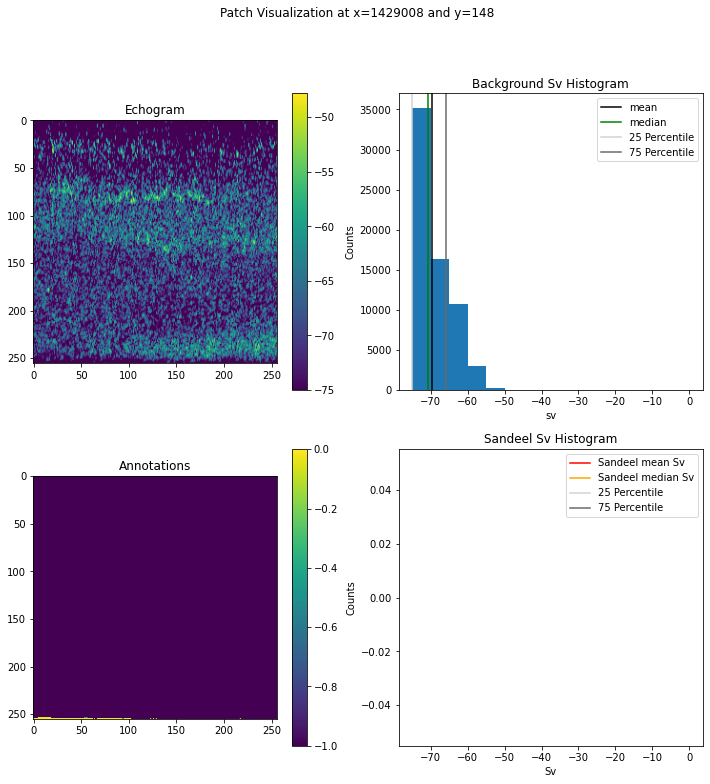

mean background Sv = -66.30895  median background Sv = -65.87556


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


mean Sandeel Sv = nan  median Sandeel Sv = nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


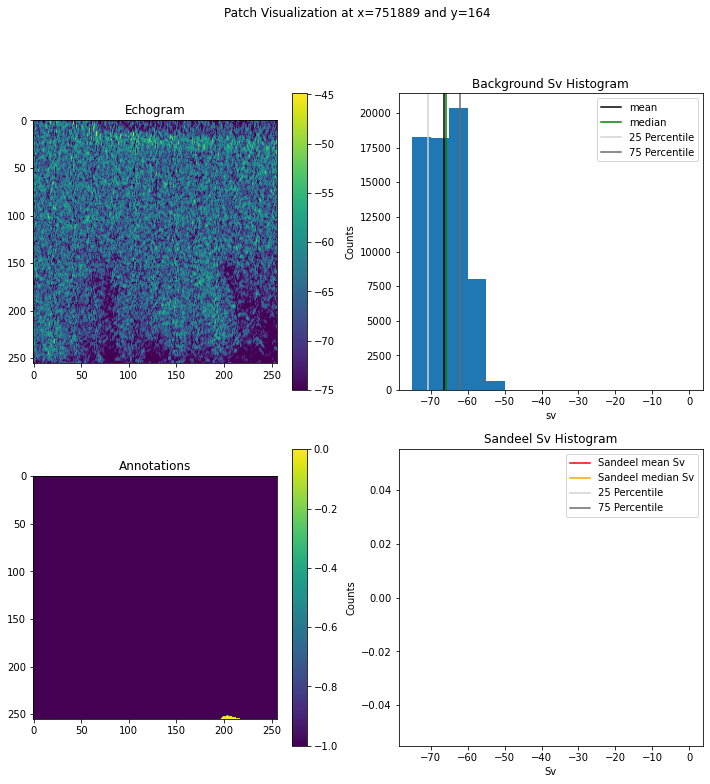

mean background Sv = -67.33026  median background Sv = -68.12985


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


mean Sandeel Sv = nan  median Sandeel Sv = nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


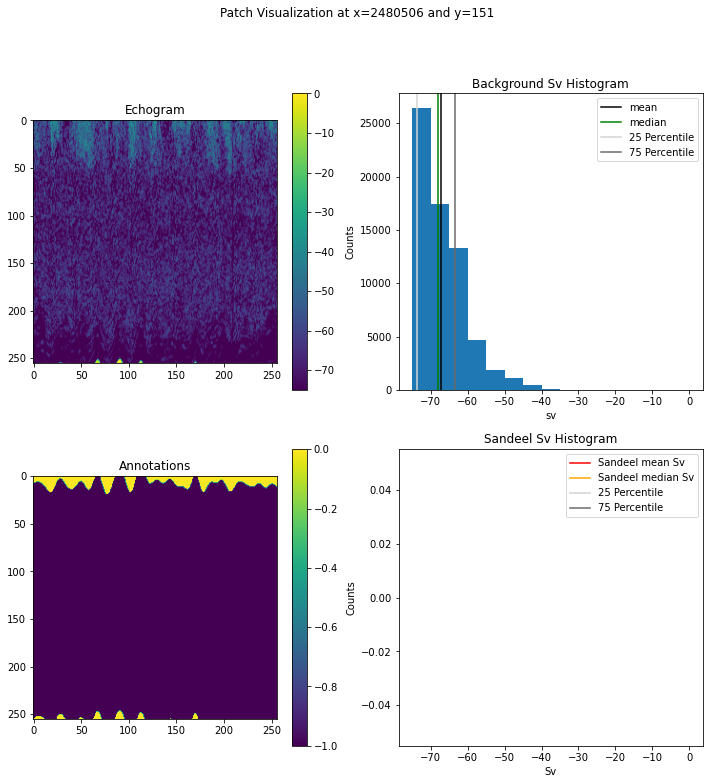

In [100]:
# Random 3 patch visualization

for i in np.random.randint(0,15000,3):
    examp_illustr(survey[0], x=cordinates_bg_rand[i,0], y=cordinates_bg_rand[i,1])

# Extracting Statistics from the  random bg patches

In [ ]:
# x, y, mean, median, n_pixels_below_seabed, Nr of fish categories + ignore + background
data = np.zeros((len(cordinates_bg_rand), 53))  ## UPDATE EDILECEK
quantiles = [0, 0.25, 0.5, 0.75, 0.95, 1]
survey = readers[0]

for i, (x, y) in tqdm(enumerate(cordinates_bg_rand), total=len(cordinates_bg_rand)):
    # Data Loading & Preparations
    org_sv = survey.get_data_slice(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                   idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                   return_numpy=False, frequencies=[38000, 200000])
    data_Sv = xr_db_with_limits(org_sv)
    seabed_mask = survey.get_seabed_mask(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                         idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                         return_numpy=False)
    labels = survey.annotation.annotation[:, (x - patch_size[0] // 2):(x + patch_size[0] // 2),
             int(y - patch_size[1] // 2):int(y + patch_size[1] // 2)]
    y_label = survey.get_label_slice(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                     idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                     return_numpy=True)
    modified = P_refine_label_boundary(ignore_zero_inside_bbox=False,
                                       threshold_val=[1e-07, 1e-04], frequencies=[38, 200])(data=org_sv.values,
                                                                                            labels=y_label,
                                                                                            echogram=org_sv.values)
    modified = modified[1]  # Final 2D modified annotations
    np_Sv = data_Sv.sel(frequency=38000).values  # Sv data slice in 38 kHz frequency

    # Coordinates
    data[i, 0] = x
    data[i, 1] = y

    # Patch Statistics
    data[i, 2] = mean_Sv = np.nanmean(np_Sv)  # mean (excluding nan)
    data[i, 3] = mode_Sv = st.mode(np_Sv.flatten())[0]  # mode (excluding nan)
    data[i, 4] = np.nanstd(np_Sv)  # standard deviation (excluding nan)
    data[i, 5], data[i, 6], data[i, 7], data[i, 8], data[i, 9], data[i, 10] = np.nanquantile(np_Sv, q=quantiles)

    # Number of Pixels
    data[i, 11] = seabed_mask.sum().values  # Pixels below seabed
    data[i, 12] = len(modified[modified == 1])  # Other class
    data[i, 13] = len(modified[modified == 27])  # Sandeel class
    data[i, 14] = len(modified[modified == 6009])  # Possible Sandeel class
    data[i, 15] = np.isnan(np_Sv).sum()  # Number of nan pixels
    data[i, 16] = 256 * 256 - (
                data[i, 12] + data[i, 13] + data[i, 14] + data[i, 15])  # Background class (Excluding nan values)

    # Class Statistics

    # Other Class
    if data[i, 12] != 0:
        ot_filt = np_Sv[modified == 1]
        # Mean, Mode, Std Other Sv
        data[i, 17], data[i, 18], data[i, 19] = ot_filt.mean(), st.mode(ot_filt.flatten())[0], np.std(ot_filt)
        # 0 0.25 0.5 0.75 0.95 1 Quantiles
        data[i, 20], data[i, 21], data[i, 22], data[i, 23], data[i, 24], data[i, 25] = np.quantile(ot_filt, q=quantiles)

    # Sandeel Class
    if data[i, 13] != 0:
        sd_filt = np_Sv[modified == 27]
        # Mean, Mode, Std Sandeel Sv
        data[i, 26], data[i, 27], data[i, 28] = sd_filt.mean(), st.mode(sd_filt.flatten())[0], np.std(sd_filt)
        # 0 0.25 0.5 0.75 0.95 1 Quantiles
        data[i, 29], data[i, 30], data[i, 31], data[i, 32], data[i, 33], data[i, 34] = np.quantile(sd_filt, q=quantiles)

    # Possible Sandeel Class
    if data[i, 14] != 0:
        ps_filt = np_Sv[modified == 6009]
        # Mean, Mode, Std possible Sandeel Sv
        data[i, 35], data[i, 36], data[i, 37] = ps_filt.mean(), st.mode(ps_filt.flatten())[0], np.std(ps_filt)
        # 0 0.25 0.5 0.75 0.95 1 Quantiles
        data[i, 38], data[i, 39], data[i, 40], data[i, 41], data[i, 42], data[i, 43] = np.quantile(sd_filt, q=quantiles)

    # Background
    if data[i, 16] == 256 * 256:
        # If there is no fish, statistics are the same as patch
        data[i, 44], data[i, 45], data[i, 46] = data[i, 2], data[i, 3], data[i, 4]
        data[i, 47], data[i, 48], data[i, 49], data[i, 50], data[i, 51], data[i, 52] = data[i, 20], data[i, 21], data[
            i, 22], data[i, 23], data[i, 24], data[i, 25]
    else:
        bg_flt = np_Sv[np.logical_or((modified == 0), (modified == -1))]
        # Mean, Mode, Std Background Sv
        data[i, 44], data[i, 45], data[i, 46] = np.nanmean(bg_flt), st.mode(bg_flt.flatten(), nan_policy='omit')[
            0], np.nanstd(bg_flt)
        # 0 0.25 0.5 0.75 0.95 1 Quantiles
        data[i, 47], data[i, 48], data[i, 49], data[i, 50], data[i, 51], data[i, 52] = np.nanquantile(bg_flt,
                                                                                                      q=quantiles)

  0%|          | 1/35000 [00:01<11:37:33,  1.20s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 3/35000 [00:03<12:28:02,  1.28s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launche

  0%|          | 126/35000 [02:39<12:18:25,  1.27s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 128/35000 [02:41<11:51:20,  1.22s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_lau

  1%|          | 194/35000 [04:01<12:03:57,  1.25s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  1%|          | 203/35000 [04:12<11:52:50,  1.23s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_lau

  1%|          | 243/35000 [05:01<11:32:53,  1.20s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  1%|          | 256/35000 [05:16<11:26:19,  1.19s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_lau

  1%|          | 336/35000 [06:53<11:32:06,  1.20s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  1%|          | 366/35000 [07:29<11:31:35,  1.20s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_lau

  1%|▏         | 483/35000 [09:50<11:21:29,  1.18s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  1%|▏         | 489/35000 [09:57<11:21:51,  1.19s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_lau

  2%|▏         | 563/35000 [11:27<11:33:03,  1.21s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  2%|▏         | 590/35000 [11:59<11:13:56,  1.18s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_lau

  2%|▏         | 677/35000 [13:43<11:09:49,  1.17s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  2%|▏         | 684/35000 [13:52<11:35:32,  1.22s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_lau

  2%|▏         | 748/35000 [15:08<11:49:47,  1.24s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  2%|▏         | 749/35000 [15:09<11:25:22,  1.20s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_lau

  2%|▏         | 839/35000 [16:57<11:10:13,  1.18s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  2%|▏         | 856/35000 [17:17<11:11:18,  1.18s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_lau

  3%|▎         | 966/35000 [19:29<11:05:39,  1.17s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  3%|▎         | 970/35000 [19:33<11:06:52,  1.18s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_lau

  3%|▎         | 1071/35000 [21:33<10:51:34,  1.15s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  3%|▎         | 1076/35000 [21:39<11:08:52,  1.18s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  3%|▎         | 1124/35000 [22:37<11:42:29,  1.24s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  3%|▎         | 1132/35000 [22:46<11:24:08,  1.21s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  4%|▎         | 1226/35000 [24:40<11:22:08,  1.21s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  4%|▎         | 1236/35000 [24:52<10:57:38,  1.17s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  4%|▎         | 1303/35000 [26:12<10:53:00,  1.16s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  4%|▍         | 1313/35000 [26:24<11:08:49,  1.19s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  4%|▍         | 1349/35000 [27:07<11:01:22,  1.18s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  4%|▍         | 1352/35000 [27:11<11:00:36,  1.18s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  4%|▍         | 1431/35000 [28:45<11:06:11,  1.19s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  4%|▍         | 1439/35000 [28:54<10:51:07,  1.16s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  4%|▍         | 1559/35000 [31:17<10:54:47,  1.17s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  4%|▍         | 1562/35000 [31:21<11:14:23,  1.21s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  5%|▍         | 1618/35000 [32:28<10:53:14,  1.17s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  5%|▍         | 1626/35000 [32:38<10:51:16,  1.17s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  5%|▌         | 1754/35000 [35:13<10:52:51,  1.18s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  5%|▌         | 1767/35000 [35:28<10:57:40,  1.19s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  5%|▌         | 1885/35000 [37:48<10:51:12,  1.18s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  5%|▌         | 1889/35000 [37:53<10:51:25,  1.18s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  6%|▌         | 1948/35000 [39:03<10:50:33,  1.18s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  6%|▌         | 1968/35000 [39:27<10:58:54,  1.20s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  6%|▌         | 2031/35000 [40:43<10:57:29,  1.20s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  6%|▌         | 2036/35000 [40:49<10:51:04,  1.19s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  6%|▌         | 2120/35000 [42:30<10:56:34,  1.20s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  6%|▌         | 2137/35000 [42:51<11:11:27,  1.23s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  6%|▋         | 2214/35000 [44:23<11:03:11,  1.21s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  6%|▋         | 2217/35000 [44:26<10:56:10,  1.20s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  7%|▋         | 2291/35000 [45:55<10:41:48,  1.18s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  7%|▋         | 2296/35000 [46:01<10:47:50,  1.19s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  7%|▋         | 2357/35000 [47:13<10:44:24,  1.18s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  7%|▋         | 2360/35000 [47:17<10:41:37,  1.18s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  7%|▋         | 2438/35000 [48:49<10:27:44,  1.16s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  7%|▋         | 2447/35000 [49:00<10:50:54,  1.20s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  7%|▋         | 2506/35000 [50:12<10:41:01,  1.18s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  7%|▋         | 2519/35000 [50:27<10:48:51,  1.20s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  7%|▋         | 2605/35000 [52:10<10:34:55,  1.18s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  7%|▋         | 2613/35000 [52:20<10:42:11,  1.19s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  8%|▊         | 2686/35000 [53:47<10:29:44,  1.17s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  8%|▊         | 2701/35000 [54:05<10:39:07,  1.19s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

  8%|▊         | 2795/35000 [55:57<10:27:59,  1.17s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  8%|▊         | 2809/35000 [56:13<10:27:50,  1.17s/it]/opt/conda/lib/python3.7/site-packages/ipykernel_l

In [ ]:
# Saving & Loading the Metadata

In [137]:
data[:,16] = 256 * 256 - (data[:, 12] + data[:, 13] + data[:, 14] + data[:, 15]) # nop_bg correction
np.savetxt("Sv_BGSAMPLER_modified_patch_data.csv", data, delimiter=",")
BG_Sv_data = np.loadtxt('Sv_BGSAMPLER_modified_patch_data.csv', delimiter=",")

pdata = pd.DataFrame(BG_Sv_data)

names_modified = ['x', 'y', 'mean_Sv', 'mode_Sv', 'std_Sv', 
                  '0_Sv', '25_Sv', '50_Sv', '75_Sv', '95_Sv', '100_Sv',
                  'nop_below_seabed', 'nop_other', 'nop_sandeel', 'nop_possandeel', 'nop_nan','nop_background',
                  'mean_other', 'mode_other', 'std_other',
                  '0_Other', '25_Other', '50_Other', '75_Other', '95_Other', '100_Other',
                  'mean_sandeel', 'mode_sandeel', 'std_sandeel',
                  '0_sandeel', '25_sandeel', '50_sandeel', '75_sandeel', '95_sandeel', '100_sandeel',
                  'mean_psandeel', 'mode_psandeel', 'std_psandeel',
                  '0_psandeel', '25_psandeel', '50_psandeel', '75_psandeel', '95_psandeel', '100_psandeel',
                  'mean_bg', 'mode_bg', 'std_bg',
                  '0_bg', '25_bg', '50_bg', '75_bg', '95_bg', '100_bg']
pdata.columns = names_modified
pdata[pdata['nop_nan']>=65536]
#pdata.info()

,x,y,mean_Sv,mode_Sv,std_Sv,0_Sv,25_Sv,50_Sv,75_Sv,95_Sv,100_Sv,nop_below_seabed,nop_other,nop_sandeel,nop_possandeel,nop_nan,nop_background,mean_other,mode_other,std_other,0_Other,25_Other,50_Other,75_Other,95_Other,100_Other,mean_sandeel,mode_sandeel,std_sandeel,0_sandeel,25_sandeel,50_sandeel,75_sandeel,95_sandeel,100_sandeel,mean_psandeel,mode_psandeel,std_psandeel,0_psandeel,25_psandeel,50_psandeel,75_psandeel,95_psandeel,100_psandeel,mean_bg,mode_bg,std_bg,0_bg,25_bg,50_bg,75_bg,95_bg,100_bg
1,2073195.0,2286.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3521409.0,1542.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,3511714.0,2233.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,3503515.0,1848.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,2003948.0,674.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34975,2056101.0,858.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34976,2020158.0,1147.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34981,2038800.0,1241.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34988,1986605.0,1484.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1024.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
sb = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']==0)]) # Sandeel + Background
so = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']==0)]) # Sandeel + Other
sp = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']>0)]) # Sandeel + Possandeel
spo = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']>0)]) # Sandeel + Possandeel + Other

ob = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']==0)]) # Other + Background
op = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']>0)]) # Other + Possandeel
pb = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']>0)]) # Possandeel + Background

b = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']==0)]) # Possandeel + Background

info = np.array([sb, so, sp, spo, ob, op, pb, b], ndmin = 2)
names = np.array(['Sand, Bg', 'Sand, Oth', 'Sand, PosSand', 'Sand, PosSand, Bg',
                      'Oth, Bg', 'Oth, PosSand', 'PosSand, Bg', 'Bg'], ndmin = 2)
info, names

(array([[    0,     0,     0,     0,     0,     0,     0, 35000]]),
 array([['Sand, Bg', 'Sand, Oth', 'Sand, PosSand', 'Sand, PosSand, Bg',
         'Oth, Bg', 'Oth, PosSand', 'PosSand, Bg', 'Bg']], dtype='<U17'))

# Patches Data Summary Visualizations

In [139]:
# Class Label Assignment
pdata['class'] = 'background'
pdata.loc[(pdata['nop_other']>0) & (pdata['nop_sandeel']==0)
          & (pdata['nop_below_seabed']==0), 'class'] = 'other'
pdata.loc[(pdata['nop_other']==0) & (pdata['nop_sandeel']>0)
          & (pdata['nop_below_seabed']==0), 'class'] = 'sandeel'
pdata.loc[(pdata['nop_other']==0) & (pdata['nop_sandeel']==0)
          & (pdata['nop_below_seabed']>0) & (pdata['nop_below_seabed']!=256*256), 'class'] = 'seabed'
pdata.loc[(pdata['nop_other']==0) & (pdata['nop_sandeel']>0)
          & (pdata['nop_below_seabed']>0) & (pdata['nop_below_seabed']!=256*256), 'class'] = 'seabed_sandeel'
pdata.loc[(pdata['nop_other']>0) & (pdata['nop_sandeel']==0)
          & (pdata['nop_below_seabed']>0) & (pdata['nop_below_seabed']!=256*256), 'class'] = 'seabed_other'
pdata.loc[(pdata['nop_other']>0) & (pdata['nop_sandeel']>0)
          & (pdata['nop_below_seabed']==0), 'class'] = 'sandeel_other'
pdata.loc[(pdata['nop_other']>0) & (pdata['nop_sandeel']>0)
          & (pdata['nop_below_seabed']>0) & (pdata['nop_below_seabed']!=256*256), 'class'] = 'seabed_sandeel_other'

pdata[pdata['class']=='seabed']

,x,y,mean_Sv,mode_Sv,std_Sv,0_Sv,25_Sv,50_Sv,75_Sv,95_Sv,100_Sv,nop_below_seabed,nop_other,nop_sandeel,nop_possandeel,nop_nan,nop_background,mean_other,mode_other,std_other,0_Other,25_Other,50_Other,75_Other,95_Other,100_Other,mean_sandeel,mode_sandeel,std_sandeel,0_sandeel,25_sandeel,50_sandeel,75_sandeel,95_sandeel,100_sandeel,mean_psandeel,mode_psandeel,std_psandeel,0_psandeel,25_psandeel,50_psandeel,75_psandeel,95_psandeel,100_psandeel,mean_bg,mode_bg,std_bg,0_bg,25_bg,50_bg,75_bg,95_bg,100_bg,class
2,2313629.0,151.0,-70.599792,-75.0,4.847128,-75.0,-75.000000,-71.892845,-67.463242,-61.616657,-40.989208,14.0,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-70.599792,-75.0,4.847128,0.0,0.0,0.0,0.0,0.0,0.0,seabed
4,2326858.0,163.0,-69.175339,-75.0,4.713405,-75.0,-73.921131,-69.304241,-65.659527,-61.165077,-22.921410,20.0,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-69.175339,-75.0,4.713405,0.0,0.0,0.0,0.0,0.0,0.0,seabed
5,2701816.0,180.0,-67.142960,-75.0,5.250220,-75.0,-71.449444,-66.985901,-63.108139,-58.669104,-18.679104,27.0,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-67.142960,-75.0,5.250220,0.0,0.0,0.0,0.0,0.0,0.0,seabed
6,2344237.0,156.0,-66.990044,-75.0,5.543521,-75.0,-71.529400,-66.850231,-62.987516,-58.053865,-40.846268,9.0,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-66.990044,-75.0,5.543521,0.0,0.0,0.0,0.0,0.0,0.0,seabed
7,366995.0,149.0,-71.041977,-75.0,5.091719,-75.0,-75.000000,-74.746773,-67.315416,-60.865780,-47.949654,33.0,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-71.041977,-75.0,5.091719,0.0,0.0,0.0,0.0,0.0,0.0,seabed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34990,1779529.0,161.0,-69.551529,-75.0,5.087101,-75.0,-75.000000,-70.253914,-65.789911,-60.377967,-47.794193,61.0,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-69.551529,-75.0,5.087101,0.0,0.0,0.0,0.0,0.0,0.0,seabed
34992,3538814.0,421.0,-66.032043,-75.0,5.183682,-75.0,-69.658360,-65.656227,-62.287735,-58.254380,0.000000,98.0,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-66.032043,-75.0,5.183682,0.0,0.0,0.0,0.0,0.0,0.0,seabed
34993,3056465.0,166.0,-65.009529,-75.0,5.274842,-75.0,-68.591696,-64.492302,-61.111630,-56.991417,-28.288105,61.0,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-65.009529,-75.0,5.274842,0.0,0.0,0.0,0.0,0.0,0.0,seabed
34996,2459371.0,150.0,-70.265747,-75.0,5.679029,-75.0,-75.000000,-72.382458,-66.696882,-59.386574,-14.457932,18.0,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-70.265747,-75.0,5.679029,0.0,0.0,0.0,0.0,0.0,0.0,seabed


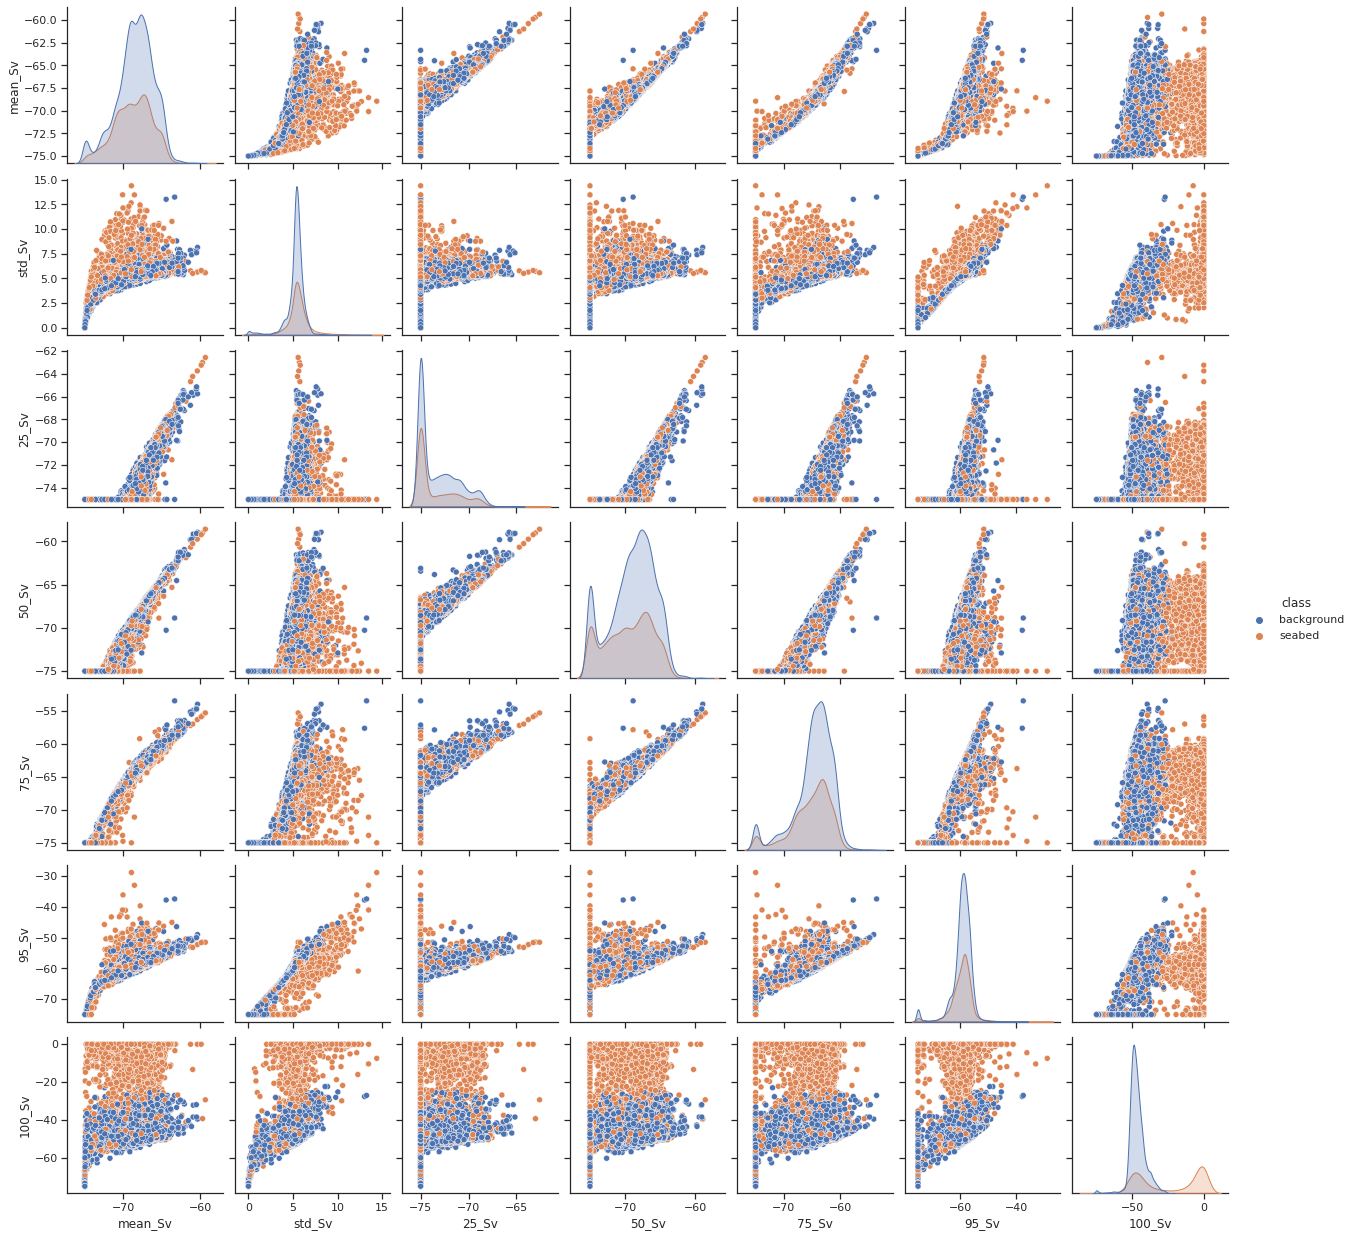

In [119]:
sns.set_theme(style="ticks")
columns = ['mean_Sv', 'std_Sv', '25_Sv', '50_Sv', '75_Sv', '95_Sv', '100_Sv', 'class']
filt = (pdata['class'] == 'background') | (pdata['class'] == 'seabed')
sns.pairplot(pdata[filt][columns], hue="class")

# Explanation: The distribution of the patches with only background, and patches containing seabed
# It seems they are distinguishable ( with std, 95% and 100% percentiles)

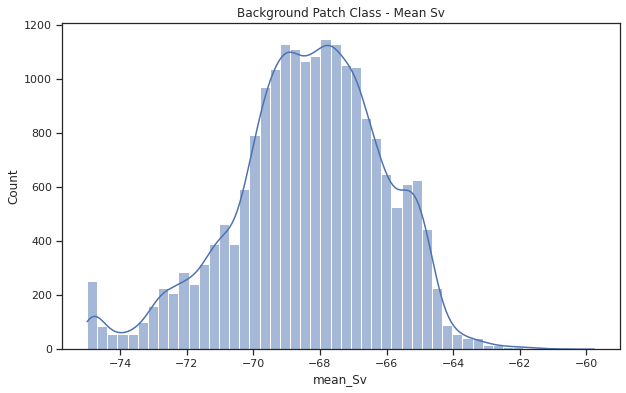

In [180]:
plt.figure(figsize=(10,6))
sns.histplot(pdata[(pdata['class']=='background') & (pdata['nop_nan']==0)]['mean_Sv'], 
             kde=True, stat="count", bins=50)
plt.title('Background Patch Class - Mean Sv')
plt.show()

# Reading Extracted Patch Data (2 patches for each ping)

In [166]:
PSv_data = np.loadtxt('Sv_modified_patch_data.csv', delimiter=",")

Ppdata = pd.DataFrame(PSv_data)
names_modified = ['x', 'y', 'mean_Sv', 'mode_Sv', 'std_Sv', 
                  '0_Sv', '25_Sv', '50_Sv', '75_Sv', '95_Sv', '100_Sv',
                  'nop_below_seabed', 'nop_other', 'nop_sandeel', 'nop_possandeel', 'nop_nan','nop_background',
                  'mean_other', 'mode_other', 'std_other',
                  '0_Other', '25_Other', '50_Other', '75_Other', '95_Other', '100_Other',
                  'mean_sandeel', 'mode_sandeel', 'std_sandeel',
                  '0_sandeel', '25_sandeel', '50_sandeel', '75_sandeel', '95_sandeel', '100_sandeel',
                  'mean_psandeel', 'mode_psandeel', 'std_psandeel',
                  '0_psandeel', '25_psandeel', '50_psandeel', '75_psandeel', '95_psandeel', '100_psandeel',
                  'mean_bg', 'mode_bg', 'std_bg',
                  '0_bg', '25_bg', '50_bg', '75_bg', '95_bg', '100_bg']
Ppdata.columns = names_modified
# Class Label Assignment
Ppdata['class'] = 'background'
Ppdata.loc[(Ppdata['nop_other']>0) & (Ppdata['nop_sandeel']==0)
          & (Ppdata['nop_below_seabed']==0), 'class'] = 'other'
Ppdata.loc[(Ppdata['nop_other']==0) & (Ppdata['nop_sandeel']>0)
          & (Ppdata['nop_below_seabed']==0), 'class'] = 'sandeel'
Ppdata.loc[(Ppdata['nop_other']==0) & (Ppdata['nop_sandeel']==0)
          & (Ppdata['nop_below_seabed']>0) & (Ppdata['nop_below_seabed']!=256*256), 'class'] = 'seabed'
Ppdata.loc[(Ppdata['nop_other']==0) & (Ppdata['nop_sandeel']>0)
          & (Ppdata['nop_below_seabed']>0) & (Ppdata['nop_below_seabed']!=256*256), 'class'] = 'seabed_sandeel'
Ppdata.loc[(Ppdata['nop_other']>0) & (Ppdata['nop_sandeel']==0)
          & (Ppdata['nop_below_seabed']>0) & (Ppdata['nop_below_seabed']!=256*256), 'class'] = 'seabed_other'
Ppdata.loc[(Ppdata['nop_other']>0) & (Ppdata['nop_sandeel']>0)
          & (Ppdata['nop_below_seabed']==0), 'class'] = 'sandeel_other'
Ppdata.loc[(Ppdata['nop_other']>0) & (Ppdata['nop_sandeel']>0)
          & (Ppdata['nop_below_seabed']>0) & (Ppdata['nop_below_seabed']!=256*256), 'class'] = 'seabed_sandeel_other'


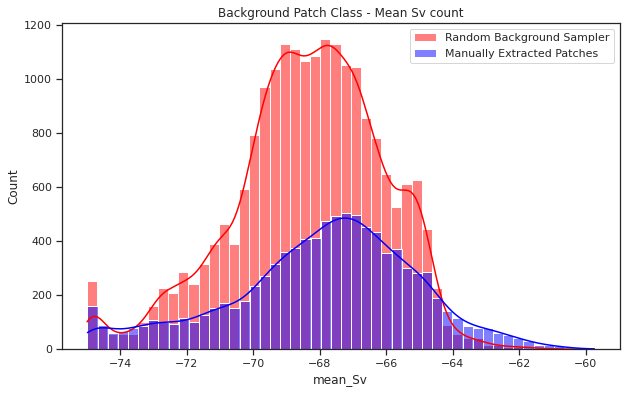

In [187]:
stat = 'count'
plt.figure(figsize=(10,6))
sns.histplot(pdata.mean_Sv[(pdata['class']=='background') & (pdata['nop_nan']==0)], 
             kde=True, color='red', bins=50, stat=stat, label='Random Background Sampler')
sns.histplot(Ppdata.mean_Sv[(Ppdata['class']=='background') & (Ppdata['nop_nan']==0)], 
             kde=True, color='blue', bins=50, stat=stat, label='Manually Extracted Patches')
plt.title(f'Background Patch Class - Mean Sv {stat}')
plt.legend()
plt.show()

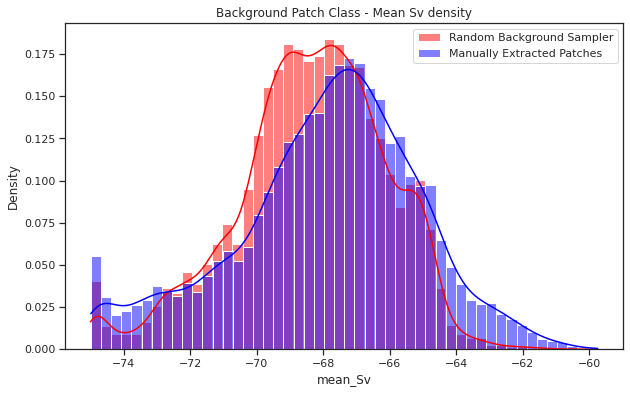

In [189]:
stat = 'density'
plt.figure(figsize=(10,6))
sns.histplot(pdata.mean_Sv[(pdata['class']=='background') & (pdata['nop_nan']==0)], 
             kde=True, color='red', bins=50, stat=stat, label='Random Background Sampler')
sns.histplot(Ppdata.mean_Sv[(Ppdata['class']=='background') & (Ppdata['nop_nan']==0)], 
             kde=True, color='blue', bins=50, stat=stat, label='Manually Extracted Patches')
plt.title(f'Background Patch Class - Mean Sv {stat}')
plt.legend()
plt.show()

In [192]:
Ppdata[(Ppdata['class']=='background') & (pdata['nop_nan']==0)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,x,y,mean_Sv,mode_Sv,std_Sv,0_Sv,25_Sv,50_Sv,75_Sv,95_Sv,100_Sv,nop_below_seabed,nop_other,nop_sandeel,nop_possandeel,nop_nan,nop_background,mean_other,mode_other,std_other,0_Other,25_Other,50_Other,75_Other,95_Other,100_Other,mean_sandeel,mode_sandeel,std_sandeel,0_sandeel,25_sandeel,50_sandeel,75_sandeel,95_sandeel,100_sandeel,mean_psandeel,mode_psandeel,std_psandeel,0_psandeel,25_psandeel,50_psandeel,75_psandeel,95_psandeel,100_psandeel,mean_bg,mode_bg,std_bg,0_bg,25_bg,50_bg,75_bg,95_bg,100_bg,class
0,128.0,148.0,-73.024147,-75.0,3.740309,-75.0,-75.000000,-75.000000,-72.643904,-64.266907,-50.807701,0.0,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-73.024147,-75.0,3.740309,-75.0,-75.000000,-75.000000,-72.643904,-64.266907,-50.807701,background
2,640.0,148.0,-73.257332,-75.0,3.570127,-75.0,-75.000000,-75.000000,-73.920282,-64.613506,-50.615807,0.0,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-73.257332,-75.0,3.570127,-75.0,-75.000000,-75.000000,-73.920282,-64.613506,-50.615807,background
4,1152.0,148.0,-74.086021,-75.0,2.553980,-75.0,-75.000000,-75.000000,-75.000000,-67.934610,-54.773499,0.0,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-74.086021,-75.0,2.553980,-75.0,-75.000000,-75.000000,-75.000000,-67.934610,-54.773499,background
5,1408.0,148.0,-74.247002,-75.0,2.278063,-75.0,-75.000000,-75.000000,-75.000000,-68.917721,-52.374722,0.0,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-74.247002,-75.0,2.278063,-75.0,-75.000000,-75.000000,-75.000000,-68.917721,-52.374722,background
6,1664.0,148.0,-74.453392,-75.0,1.828542,-75.0,-75.000000,-75.000000,-75.000000,-70.564106,-44.489410,0.0,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-74.453392,-75.0,1.828542,-75.0,-75.000000,-75.000000,-75.000000,-70.564106,-44.489410,background
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31121,3982464.0,404.0,-68.021927,-75.0,6.015134,-75.0,-74.606968,-68.517265,-63.300204,-57.646963,-43.976177,0.0,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-68.021927,-75.0,6.015134,-75.0,-74.606968,-68.517265,-63.300204,-57.646963,-43.976177,background
31123,3982976.0,404.0,-70.798698,-75.0,6.521911,-75.0,-75.000000,-74.678337,-68.578583,-55.637224,-38.410809,0.0,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-70.798698,-75.0,6.521911,-75.0,-75.000000,-74.678337,-68.578583,-55.637224,-38.410809,background
31124,3983232.0,404.0,-70.934372,-75.0,6.746030,-75.0,-75.000000,-75.000000,-69.391685,-54.532401,-38.247486,0.0,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-70.934372,-75.0,6.746030,-75.0,-75.000000,-75.000000,-69.391685,-54.532401,-38.247486,background
31125,3983488.0,404.0,-71.237091,-75.0,6.861437,-75.0,-75.000000,-75.000000,-70.468470,-54.343845,-36.009796,0.0,0.0,0.0,0.0,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-71.237091,-75.0,6.861437,-75.0,-75.000000,-75.000000,-70.468470,-54.343845,-36.009796,background
